# Módulo 1: Análisis de datos en el ecosistema Python

### Sesión (27)

**08/04/2024**

# Machine Learning Time Series Forecasting

Para aplicar modelos de aprendizaje automático (___Machine Learning___) a problemas de predicción de series temporales, **debemos transformar la serie en una matriz** en la que cada valor esté asociado a la ventana temporal con las observaciones anteriores (lags) correspondientes. Para ello tenemos que crear conjuntos de datos con las observaciones pasadas acompañadas con el último valor de la serie después de la ventana temporal.

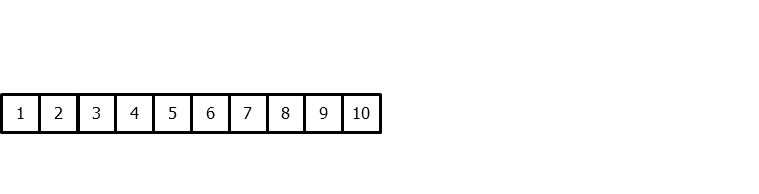

De este modo, conseguimos **convertir el problema de forecasting** o la predicción de los valores de una serie temporal **a un problema tipo regresión**, donde el modelo entrenado es capaz de calcular el próximo valor de una serie **teniendo las secuencias anteriores según el tamaño de la ventana temporal elegida** en la fase preparación de datos.  

Una vez que los datos se han reorganizado en la nueva forma, se puede **entrenar cualquier modelo de regresión** para predecir el próximo valor de la serie. Durante el entrenamiento del modelo, cada fila se considera una instancia o conjunto de datos, donde los valores en los retrasos $1, 2, ... p$ se consideran como **variables independientes o predictores** de la cantidad de la serie temporal en el paso de tiempo $p+1$.

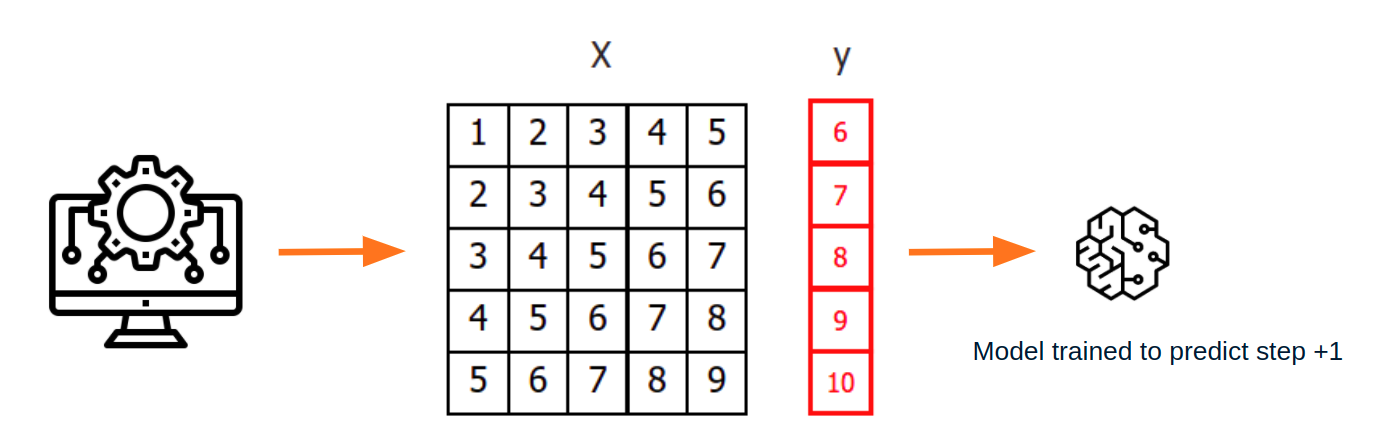

### Recursive multi-step forecasting


Dado que se requiere el valor $t_{(n-1)}$ para predecir $t_{(n)}$, cuando se desconoce $t_{(n-1)}$, podemos **aplicar un proceso recursivo** en el que, cada nuevo valor calculado, se basa en la anterior. Este proceso se conoce como predicción recursiva (___recursive forecasting___).

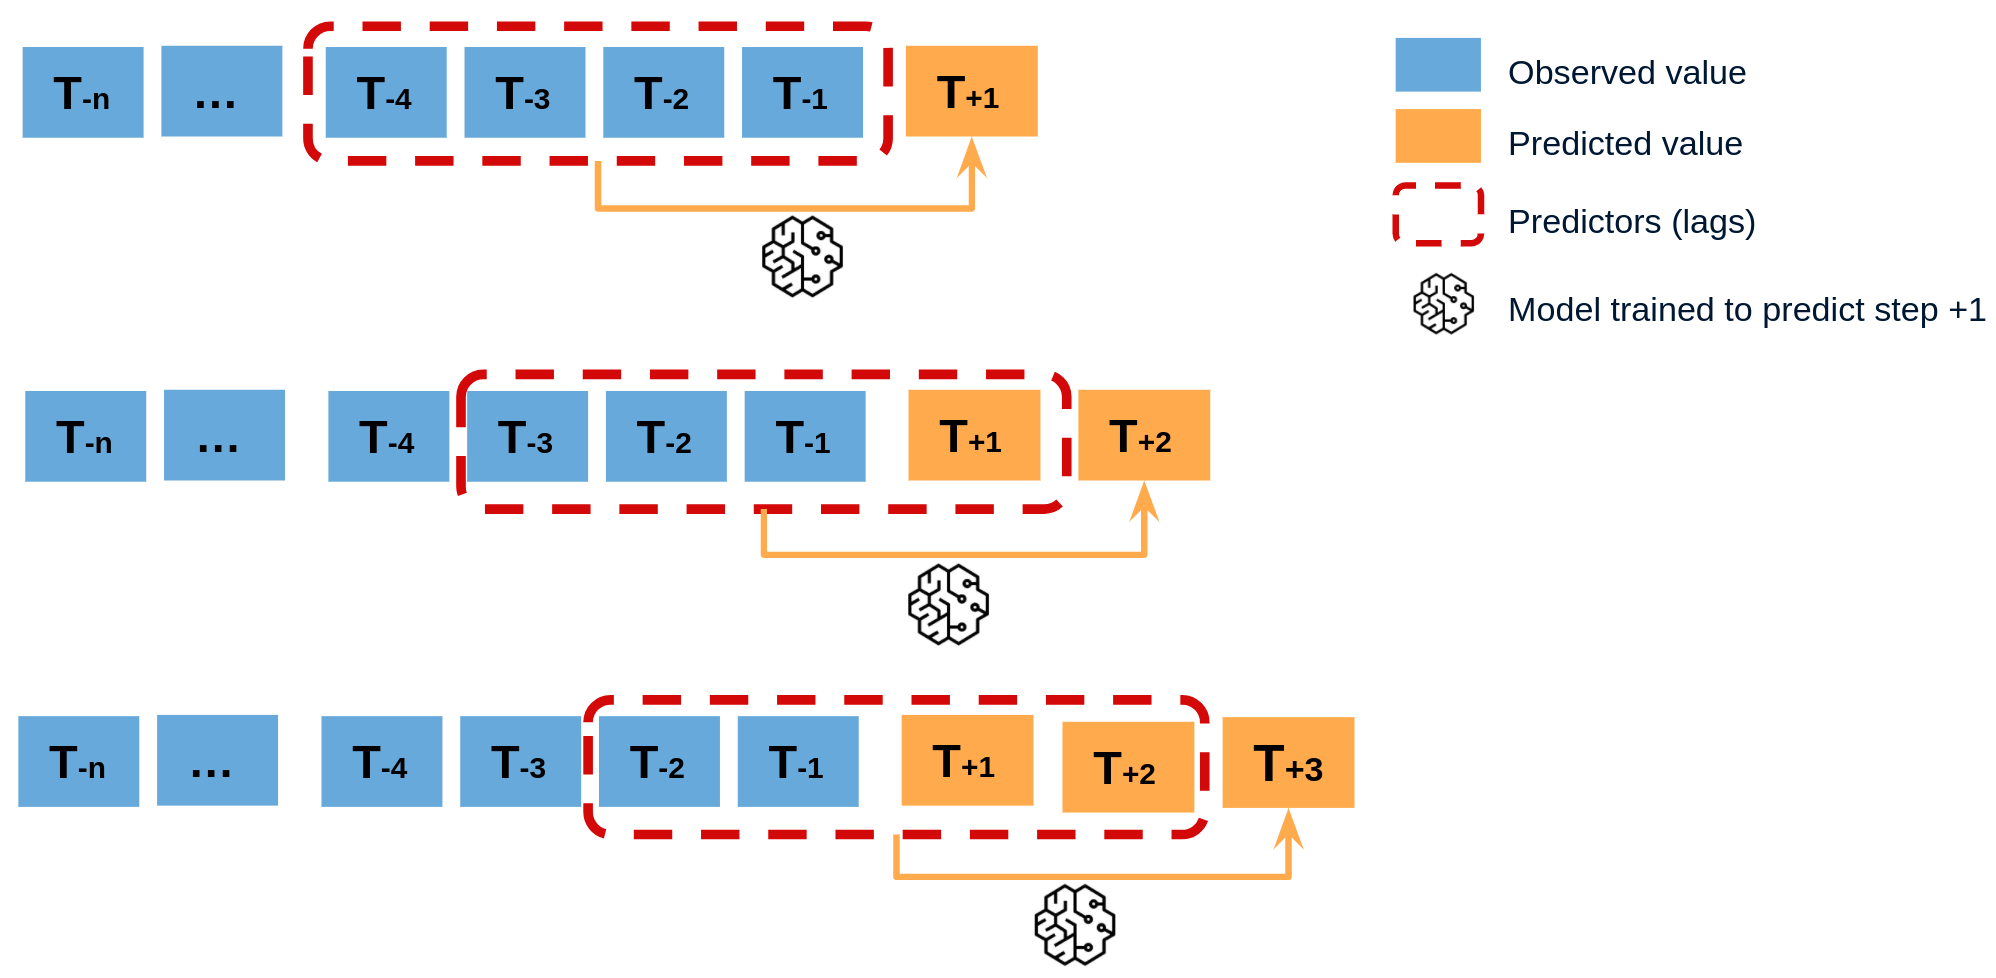

### Direct multi-step forecasting


La **predicción directa** de varios pasos consiste en **entrenar un modelo diferente para cada paso del horizonte** de predicción. Como resultado, las predicciones son independientes entre sí.

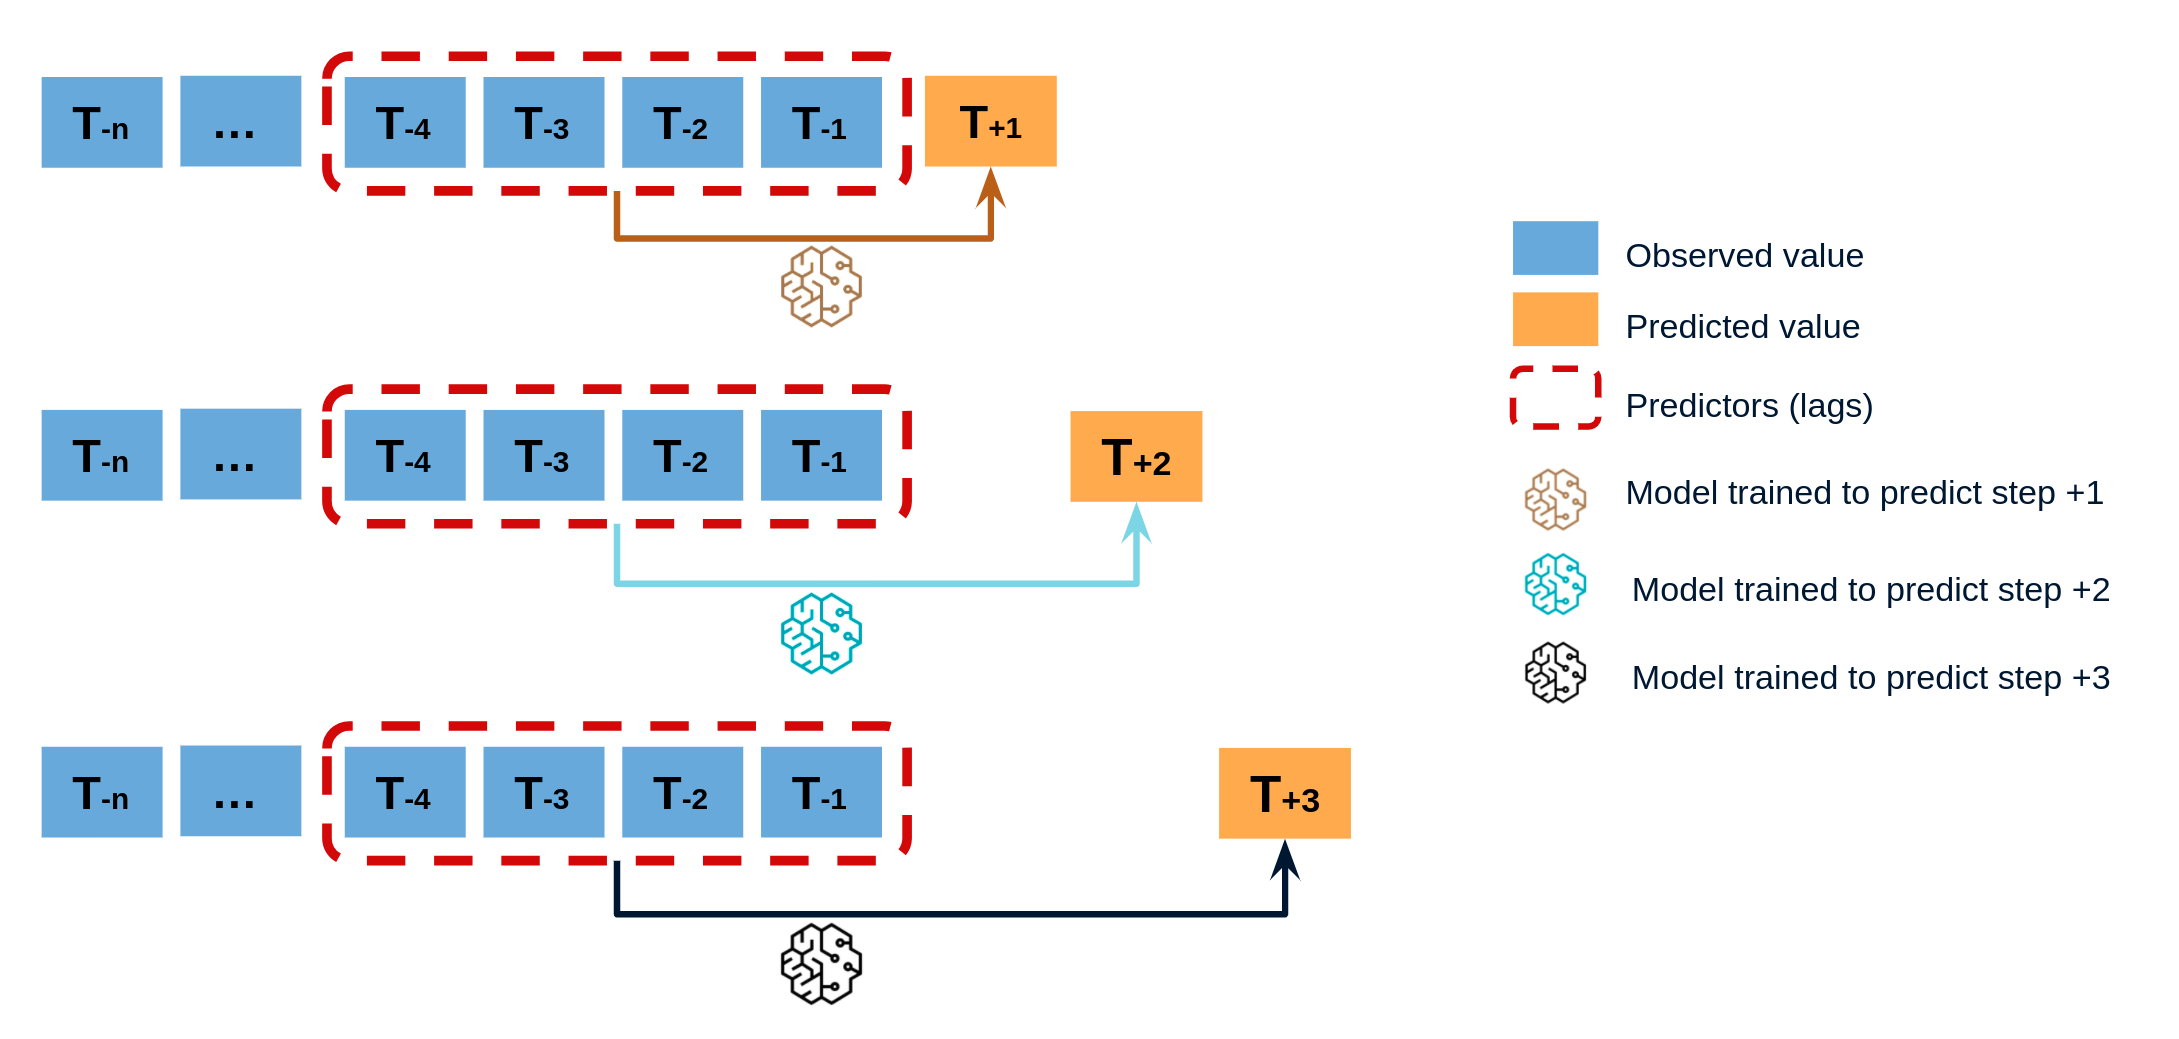

In [1]:
# importamos las librerías necesarias 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
# Modificamos los parámetros de los gráficos en matplotlib
from matplotlib.pyplot import rcParams

rcParams['figure.figsize'] = 12, 6 # el primer dígito es el ancho y el segundo el alto
rcParams["font.weight"] = "bold"
rcParams["font.size"] = 10
rcParams["axes.labelweight"] = "bold"

### Airline Passenger Dataset

Importamos los datos del ejemplo disponible en la librería ___seaborn___ que contiene el número total de pasajeros aéreos de forma mensual.

In [3]:
import seaborn as sns
import pandas as pd

# Cargar el dataset de "flights" 
df_air = sns.load_dataset('flights')
df_air

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121
...,...,...,...
139,1960,Aug,606
140,1960,Sep,508
141,1960,Oct,461
142,1960,Nov,390


In [4]:
# Consultamos la información del dataset descargado
df_air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        144 non-null    int64   
 1   month       144 non-null    category
 2   passengers  144 non-null    int64   
dtypes: category(1), int64(2)
memory usage: 2.9 KB


In [5]:
# Crear una nueva columna con la unificación de otras dos
df_air['year_month'] = df_air.apply(lambda x: str(x['year']) + '-' + x['month'], axis=1)

# Convertir la columna en fechas tipo DatetimeIndex
df_air['fechas'] = pd.to_datetime(df_air['year_month'], format='%Y-%b')

# Convertir la columna de fechas a los índices del DataFrame e indicar que los datos son "mensuales"
df_air.set_index('fechas', inplace=True)
df_air.index.freq = 'MS'

# Quitar las columnas no necesarias
df_air.drop(columns=['year', 'month', 'year_month'], inplace=True)

df_air

,passengers
fechas,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


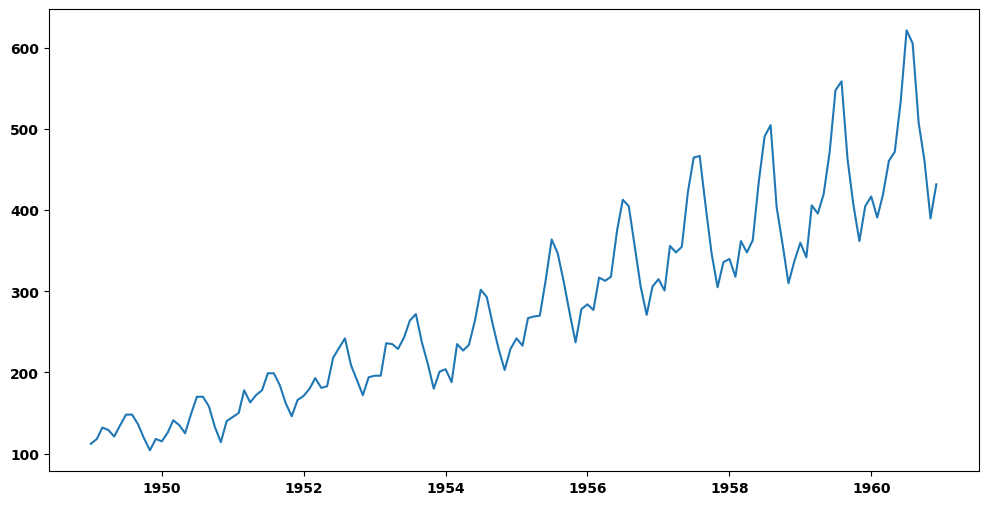

In [6]:
# Visualizar el DataFrame creado con los datos de la serie temporal
plt.plot(df_air)
plt.show()

In [7]:
# Definir el periodo de prueba (horizonte de predicción)
horizonte = 12  # La cantidad de puntos a predecir
df_test = df_air.tail(horizonte)
df_test

,passengers
fechas,
1960-01-01,417
1960-02-01,391
1960-03-01,419
1960-04-01,461
1960-05-01,472
1960-06-01,535
1960-07-01,622
1960-08-01,606
1960-09-01,508


In [8]:
# Filtrar la serie original para sacar el periodo de entrenamiento
df_train = df_air.loc[~df_air.index.isin(df_test.index)]
df_train

,passengers
fechas,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1959-08-01,559
1959-09-01,463
1959-10-01,407


### Recursive autoregressive forecasting

__`Skforecast`__ es una libraría de _Python_ para la **previsión de series temporales basada en _scikit-learn_**. Este paquete proporciona un conjunto de herramientas y modelos para trabajar con datos de series temporales, incluido el preprocesamiento, la ingeniería de variables y la predicción automatizada.

La principal ventaja de _skforecast_ es que permite el uso de la conocida interfaz _scikit-learn_ para **convertir los problemas de previsión de series temporales en problemas de regresión** y de este modo poder **aplicar distintas técnicas de Machine Learning**.

In [9]:
pip install skforecast==0.7.0

Note: you may need to restart the kernel to use updated packages.


Creamos un modelo autoregresivo usando bosques aleatrorios (_random forest_)

In [10]:
from sklearn.ensemble import RandomForestRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg


mod_rf = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=77),
                lags = 12
                )

mod_rf.fit(y=df_train['passengers'])
mod_rf

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=77) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Transformer for y: None 
Transformer for exog: None 
Window size: 12 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1949-01-01 00:00:00'), Timestamp('1959-12-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 77, 'verbose': 0, 'warm_start': False} 
Creation date: 2024-04-13 18:49:02 
Last fit date: 2024-04-13 18:49:02 
Skforecast version: 0.7.0 
Python version: 3.11.5 
Forecaster id: 

In [11]:
pred_rf = mod_rf.predict(steps=horizonte)
pred_rf

1960-01-01    412.67
1960-02-01    386.38
1960-03-01    463.01
1960-04-01    448.37
1960-05-01    480.86
1960-06-01    538.93
1960-07-01    546.14
1960-08-01    543.80
1960-09-01    526.43
1960-10-01    472.74
1960-11-01    426.54
1960-12-01    470.29
Freq: MS, Name: pred, dtype: float64

In [12]:
pred_rf = pred_rf.round()
pred_rf

1960-01-01    413.0
1960-02-01    386.0
1960-03-01    463.0
1960-04-01    448.0
1960-05-01    481.0
1960-06-01    539.0
1960-07-01    546.0
1960-08-01    544.0
1960-09-01    526.0
1960-10-01    473.0
1960-11-01    427.0
1960-12-01    470.0
Freq: MS, Name: pred, dtype: float64

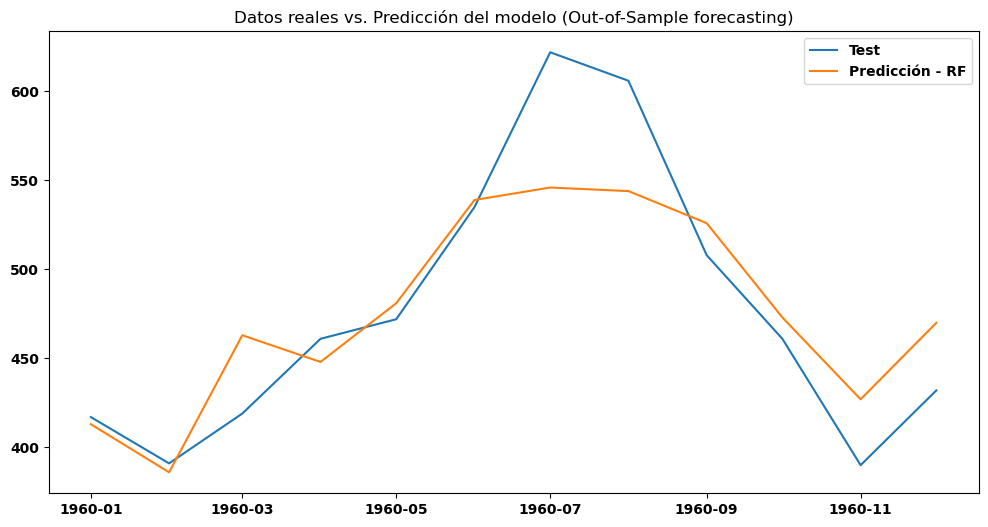

In [13]:
plt.plot(df_test, label='Test')
plt.plot(pred_rf, label='Predicción - RF')
plt.title("Datos reales vs. Predicción del modelo (Out-of-Sample forecasting)")
plt.legend()
plt.show()

In [14]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Métricas de evaluación del modelo
print('Mean Absolute Error (MAE):', mean_absolute_error(df_test, pred_rf))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(df_test, pred_rf)*100)
print('Mean Squared Error (MSE):', mean_squared_error(df_test, pred_rf))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(df_test, pred_rf)))
print('R^2 coefficient of determination:', r2_score(df_test, pred_rf))

Mean Absolute Error (MAE): 26.833333333333332
Mean Absolute Percentage Error: 5.42442420872997
Mean Squared Error (MSE): 1262.0
Root Mean Squared Error (RMSE): 35.52463933666322
R^2 coefficient of determination: 0.7721804624387603


##### **In-Sample** Model Evaluation

In [15]:
# Crear los vectores de entrenamiento
X_train, y_train = mod_rf.create_train_X_y(df_train['passengers'])

# Calcular los valores del modelo en el periodo de entrenamiento
fitted_values = mod_rf.regressor.predict(X_train)
fitted_values

array([122.39, 128.84, 141.52, 138.07, 130.12, 152.28, 169.39, 171.08,
       156.48, 135.72, 122.8 , 136.1 , 140.05, 145.85, 167.78, 162.34,
       160.77, 176.7 , 195.94, 196.63, 183.52, 160.34, 149.16, 166.41,
       172.97, 178.88, 197.52, 185.15, 186.36, 208.7 , 227.23, 235.74,
       214.55, 188.57, 175.92, 191.07, 194.14, 200.29, 222.97, 224.72,
       225.66, 239.58, 259.12, 267.58, 237.83, 215.08, 186.59, 206.99,
       211.82, 204.77, 235.5 , 236.6 , 242.8 , 262.22, 304.13, 303.06,
       261.44, 232.89, 207.73, 228.48, 238.22, 224.5 , 264.58, 266.51,
       267.94, 309.95, 349.97, 334.62, 312.  , 270.22, 239.86, 270.51,
       279.36, 276.7 , 314.15, 313.15, 315.24, 366.83, 407.9 , 395.67,
       356.72, 306.88, 273.61, 307.04, 312.7 , 306.55, 355.75, 351.37,
       356.42, 420.27, 458.02, 458.19, 397.02, 346.56, 306.17, 337.86,
       342.9 , 322.21, 365.97, 360.42, 369.09, 449.55, 500.63, 506.61,
       429.02, 364.1 , 325.85, 346.79, 357.67, 346.69, 409.54, 382.29,
      

In [16]:
fitted_values.size

120

In [17]:
type(df_train)

pandas.core.frame.DataFrame

In [18]:
df_train.size

132

In [19]:
# Ordenar las predicciones del modelo para el periodo de emtrenamiento
estim_rf = pd.Series(data=np.zeros(df_train.size), index=df_train.index, name='fitted')
estim_rf[:horizonte] = np.nan
estim_rf[horizonte:] = fitted_values
estim_rf

fechas
1949-01-01       NaN
1949-02-01       NaN
1949-03-01       NaN
1949-04-01       NaN
1949-05-01       NaN
               ...  
1959-08-01    545.66
1959-09-01    452.26
1959-10-01    401.82
1959-11-01    360.18
1959-12-01    380.87
Freq: MS, Name: fitted, Length: 132, dtype: float64

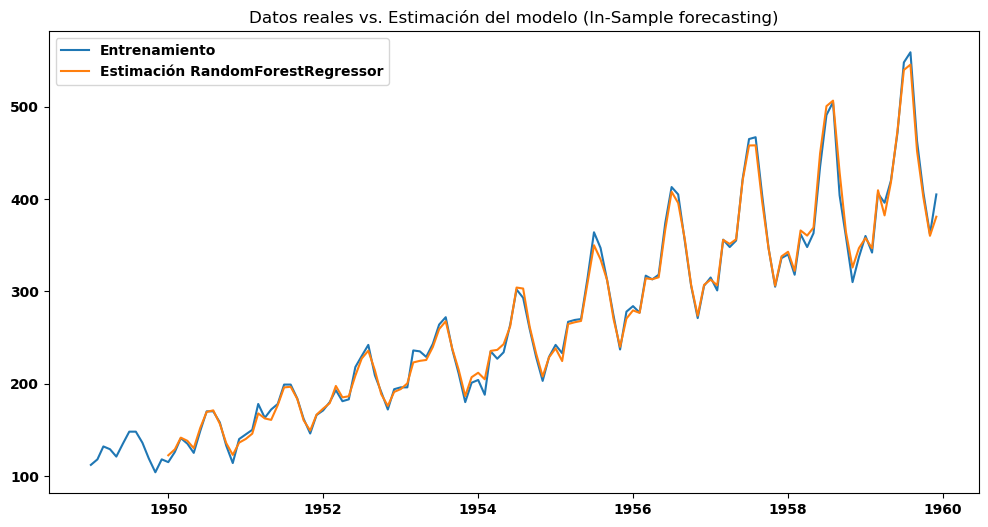

In [20]:
plt.plot(df_train, label='Entrenamiento')
plt.plot(estim_rf, label='Estimación RandomForestRegressor')
plt.title("Datos reales vs. Estimación del modelo (In-Sample forecasting)")
plt.legend()
plt.show()

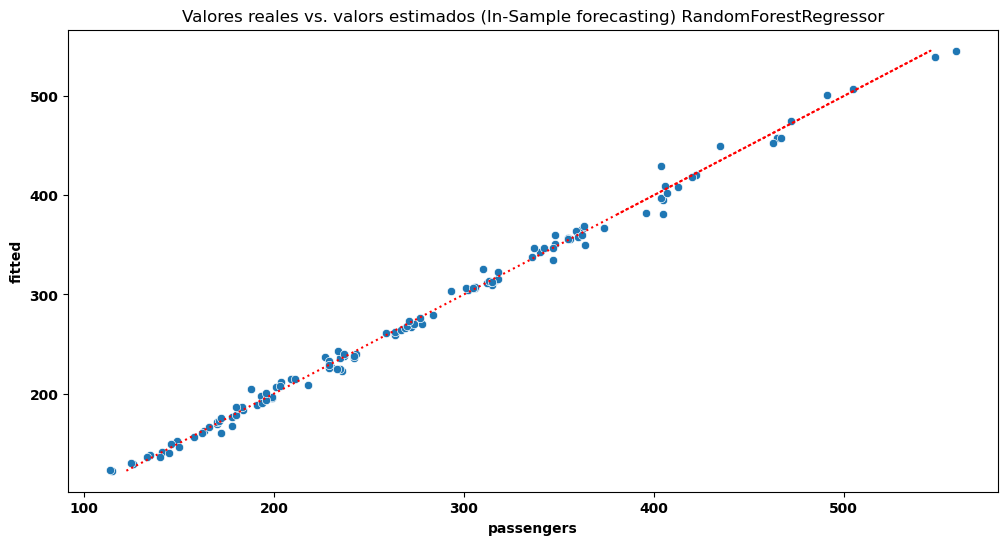

In [21]:
# Comparar los valores reales con la estimación del modelo
sns.scatterplot(x=df_train['passengers'], y=estim_rf)
plt.plot(estim_rf, estim_rf, color='r', linestyle=':')
plt.title("Valores reales vs. valors estimados (In-Sample forecasting) RandomForestRegressor")
plt.show()

In [22]:
# Calcular los valores del componente residual (In-sample errors)
resid_rf = df_train['passengers']-estim_rf
resid_rf

fechas
1949-01-01      NaN
1949-02-01      NaN
1949-03-01      NaN
1949-04-01      NaN
1949-05-01      NaN
              ...  
1959-08-01    13.34
1959-09-01    10.74
1959-10-01     5.18
1959-11-01     1.82
1959-12-01    24.13
Freq: MS, Length: 132, dtype: float64

In [23]:
# Las estadísticas del componente residual
resid_rf.describe().round(3)

count    120.000
mean       0.189
std        6.883
min      -25.020
25%       -3.628
50%        0.275
75%        3.780
max       24.130
dtype: float64

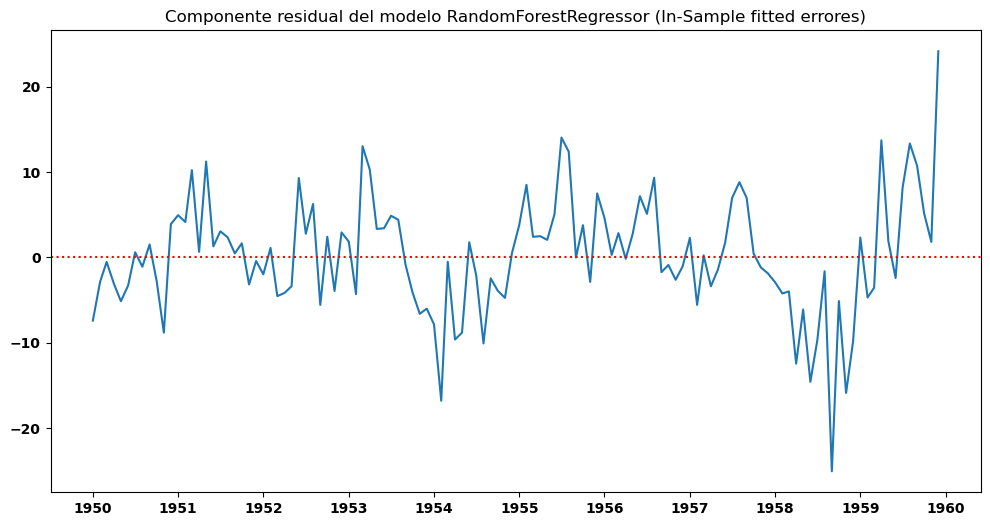

In [24]:
plt.plot(resid_rf)
plt.title("Componente residual del modelo RandomForestRegressor (In-Sample fitted errores)")
plt.axhline(y=0, color='r', linestyle=':')
plt.show()

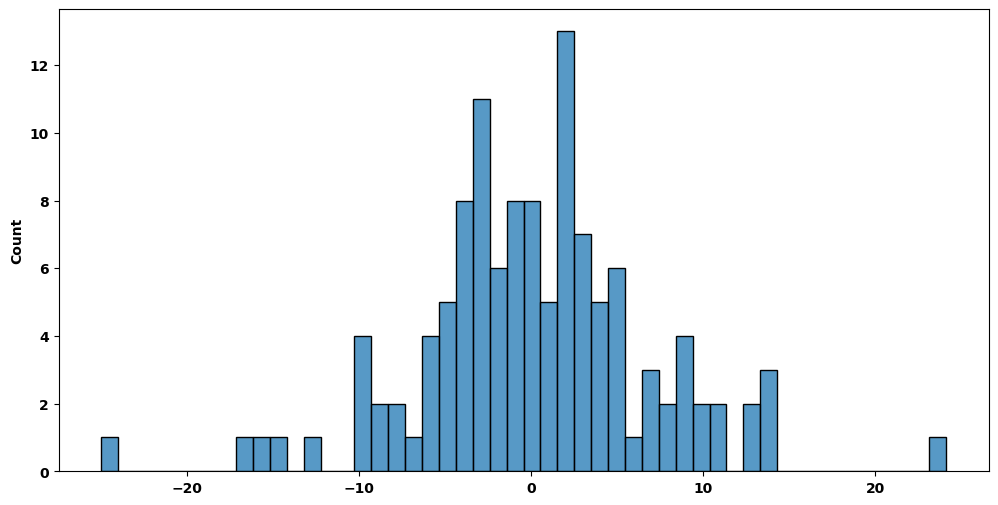

In [25]:
# El histograma del componente residual (In-sample errors)
sns.histplot(data=resid_rf, bins=50)
plt.show()

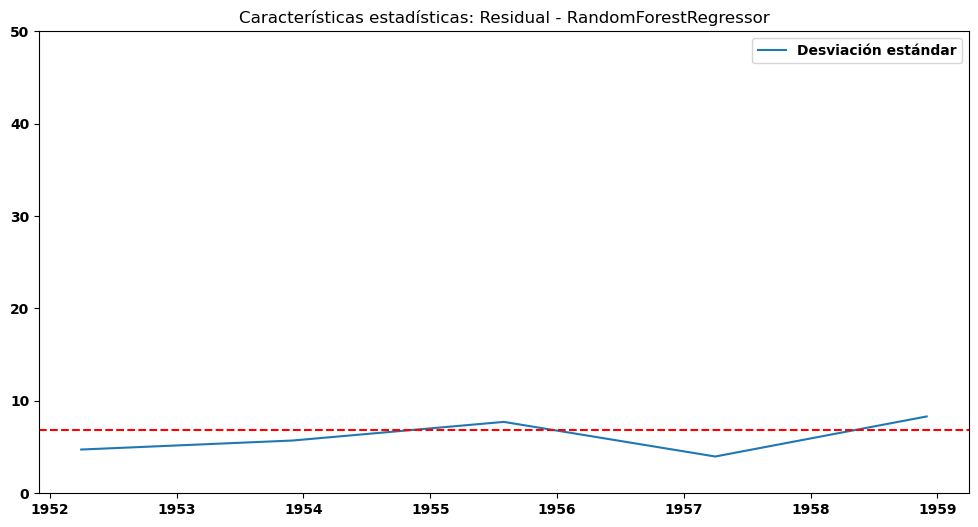

In [26]:
win = 20
resid_rf_std = resid_rf.rolling(win).std().iloc[win-1::win]
plt.plot(resid_rf_std, label='Desviación estándar')
plt.axhline(y=resid_rf.std(), color='r', linestyle='--')
plt.title("Características estadísticas: Residual - RandomForestRegressor")
plt.ylim(0,50)
plt.legend()
plt.show()

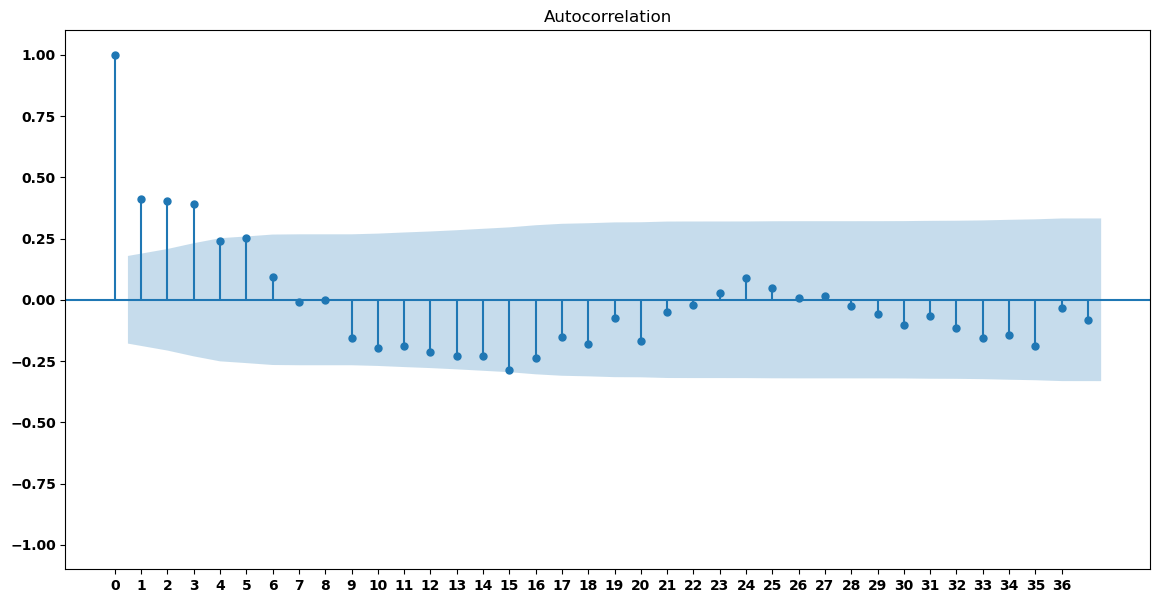

In [27]:
from statsmodels.graphics.tsaplots import plot_acf

rcParams['figure.figsize'] = 14, 7
plot_acf(resid_rf.dropna(), lags=37)
plt.xticks(np.arange(37))
plt.ylim(-1.1,1.1)
plt.show()

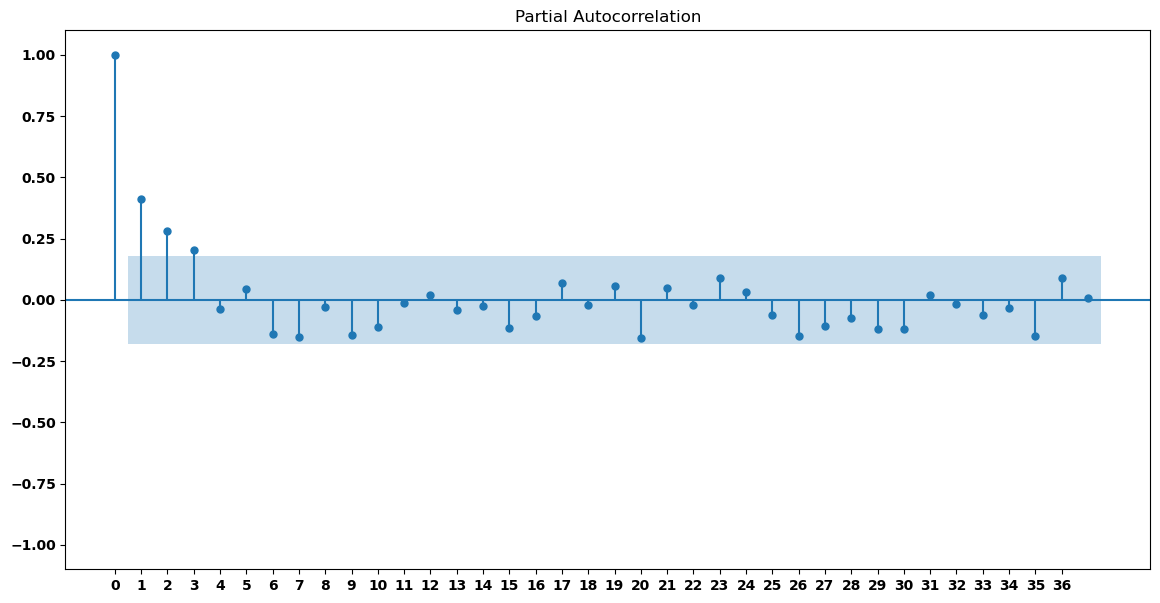

In [28]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(resid_rf.dropna(), lags=37, method='ywm')
plt.xticks(np.arange(37))
plt.ylim(-1.1,1.1)
plt.show()

Vemos que hay algo de correlación presente en los valores del componente residual

0.1702
0.1038


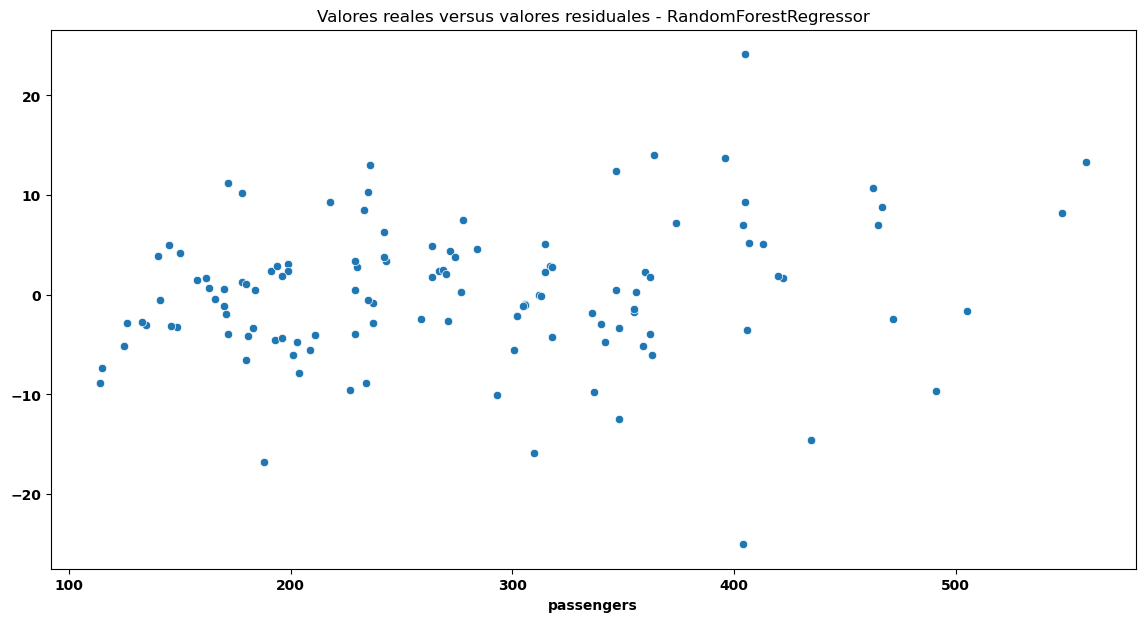

In [29]:
# Analizamos el componente residual

# Coeficiente de correlación entre valores reales y los errores
print(df_train['passengers'].corr(resid_rf).round(4))

# Coeficiente de correlación entre valores estimados y los errores
print(estim_rf.corr(resid_rf).round(4))

sns.scatterplot(x=df_train['passengers'], y=resid_rf)
plt.title("Valores reales versus valores residuales - RandomForestRegressor")
plt.show()

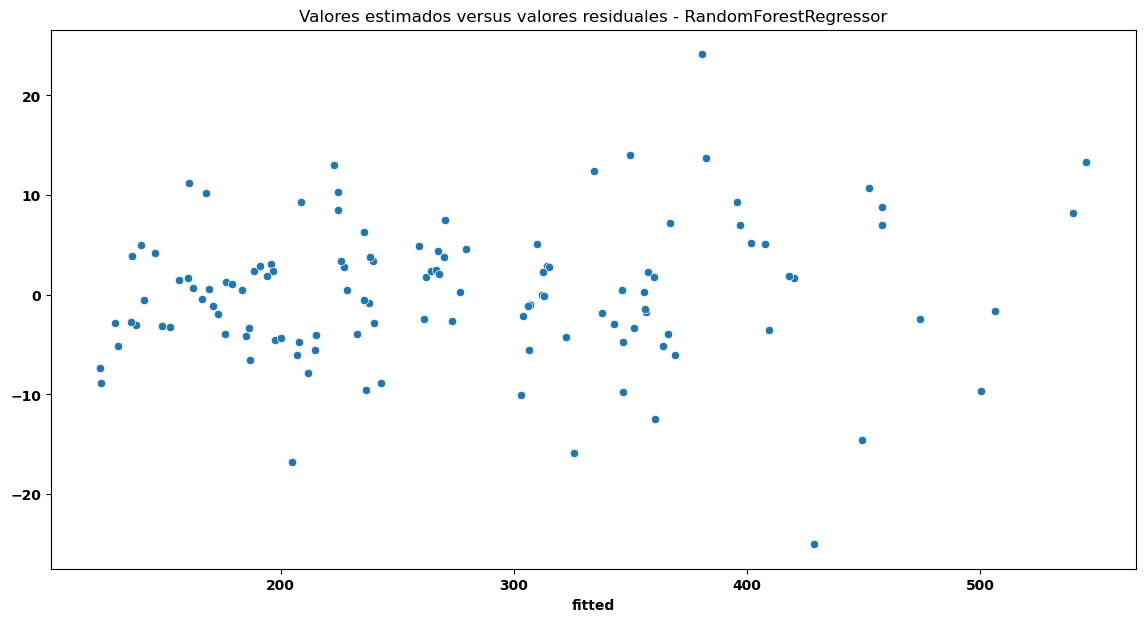

In [30]:
sns.scatterplot(x=estim_rf, y=resid_rf)
plt.title("Valores estimados versus valores residuales - RandomForestRegressor")
plt.show()

#### Analizar el intervalo de confianza

In [31]:
conf_rf = mod_rf.predict_interval(steps=horizonte, interval=[0,100], random_state=111)
conf_rf.index = df_test.index
conf_rf

,pred,lower_bound,upper_bound
fechas,,,
1960-01-01,412.67,387.65,436.80
1960-02-01,386.38,360.44,410.51
1960-03-01,463.01,437.99,488.53
1960-04-01,448.37,423.29,472.82
1960-05-01,480.86,453.90,505.67
1960-06-01,538.93,513.15,563.06
1960-07-01,546.14,520.58,570.27
1960-08-01,543.80,518.78,567.93
1960-09-01,526.43,501.41,550.56


Sacamos la banda que se aplica como intervalo de confianza: _delta_

In [32]:
conf_rf['delta'] = conf_rf.apply(lambda x: x['upper_bound'] - x['lower_bound'], axis=1)
conf_rf

,pred,lower_bound,upper_bound,delta
fechas,,,,
1960-01-01,412.67,387.65,436.80,49.15
1960-02-01,386.38,360.44,410.51,50.07
1960-03-01,463.01,437.99,488.53,50.54
1960-04-01,448.37,423.29,472.82,49.53
1960-05-01,480.86,453.90,505.67,51.77
1960-06-01,538.93,513.15,563.06,49.91
1960-07-01,546.14,520.58,570.27,49.69
1960-08-01,543.80,518.78,567.93,49.15
1960-09-01,526.43,501.41,550.56,49.15


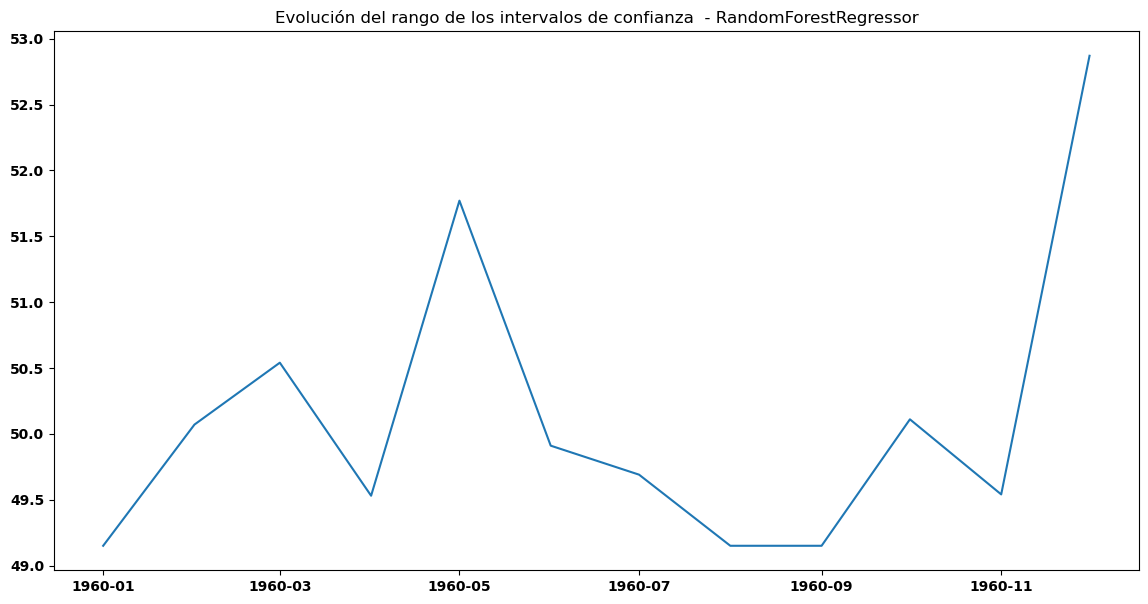

In [33]:
plt.plot(conf_rf['delta'])
plt.title("Evolución del rango de los intervalos de confianza  - RandomForestRegressor")
plt.show()

In [34]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_train.index,
    y=df_train['passengers'],
    name="Entrenamiento",
    mode="lines"
    ))

fig.add_trace(go.Scatter(
    x=df_test.index,
    y=df_test['passengers'],
    name="Test",
    mode="lines"
    ))


fig.add_trace(go.Scatter(
    x=pred_rf.index,
    y=pred_rf,
    name="Predicción (RandomForestRegressor - 12)",
    mode="markers+lines"
    ))

fig.add_trace(go.Scatter(
    x=conf_rf.index,
    y=conf_rf['lower_bound'],
    name="lower",
    mode="lines",
    line=dict(width=0),
    showlegend=False
    ))

fig.add_trace(go.Scatter(
    x=conf_rf.index,
    y=conf_rf['upper_bound'],
    name="upper",
    mode="lines",
    line=dict(width=0),
    showlegend=False,
    fillcolor='rgba(68, 68, 68, 0.3)',
    fill='tonexty'
    ))

fig.update_layout(title="Número de pasajeros aéreos de cada mes desde el año 1949 al 1960",
                  title_font_size=22,
                  xaxis_title = 'Fecha',
                  yaxis_title= 'Pasajeros'
                  )

fig.show()

### Ajustar los hiperparámetros


Una técnica común para encontrar la ventana de tiempo que marca los retrasos necesarios para modelar la serie temporal consiste en analizar el _correlograma_ normal y _parcial_

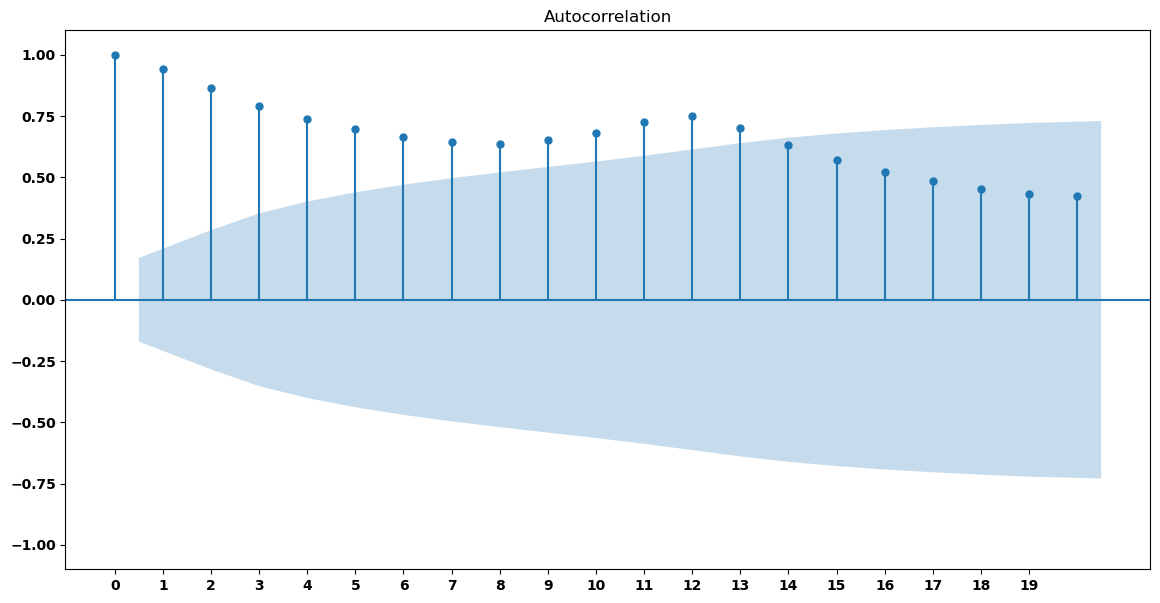

In [35]:
from statsmodels.graphics.tsaplots import plot_acf

rcParams['figure.figsize'] = 14, 7
plot_acf(df_train, lags=20)
plt.xticks(np.arange(20))
plt.ylim(-1.1,1.1)
plt.show()

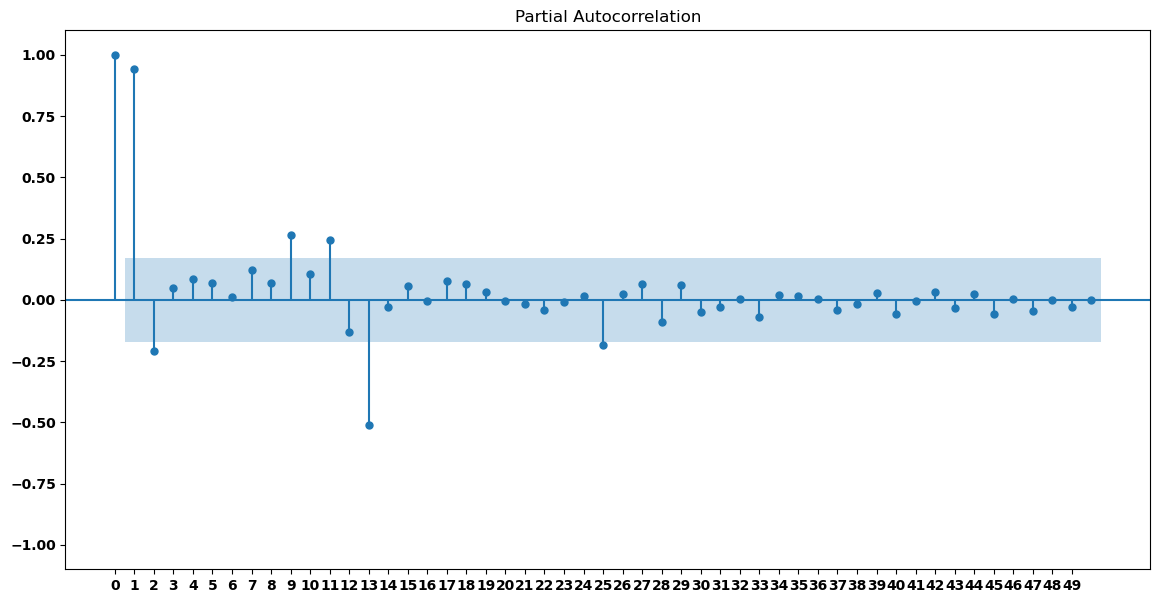

In [36]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(df_train, lags=50, method='ywm')
plt.xticks(np.arange(50))
plt.ylim(-1.1,1.1)
plt.show()

Podemos considerar una serie de posibles retrasos o _lags_ que sean importantes de cara al modelo:
- $1, 2, 3, ...., 25$
- $1, 2, 9, 12, 13$

In [37]:
# Consideramos un rango para asignar el hiperparámetro 
hiper_param = np.arange(1,26).tolist()
hiper_param.append([1,2,9,12,13])

print(hiper_param)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, [1, 2, 9, 12, 13]]


El mejor valor de lags podría ser = [1, 2, 9, 12, 13]  que consigue un R2 = 0.8095937739756596


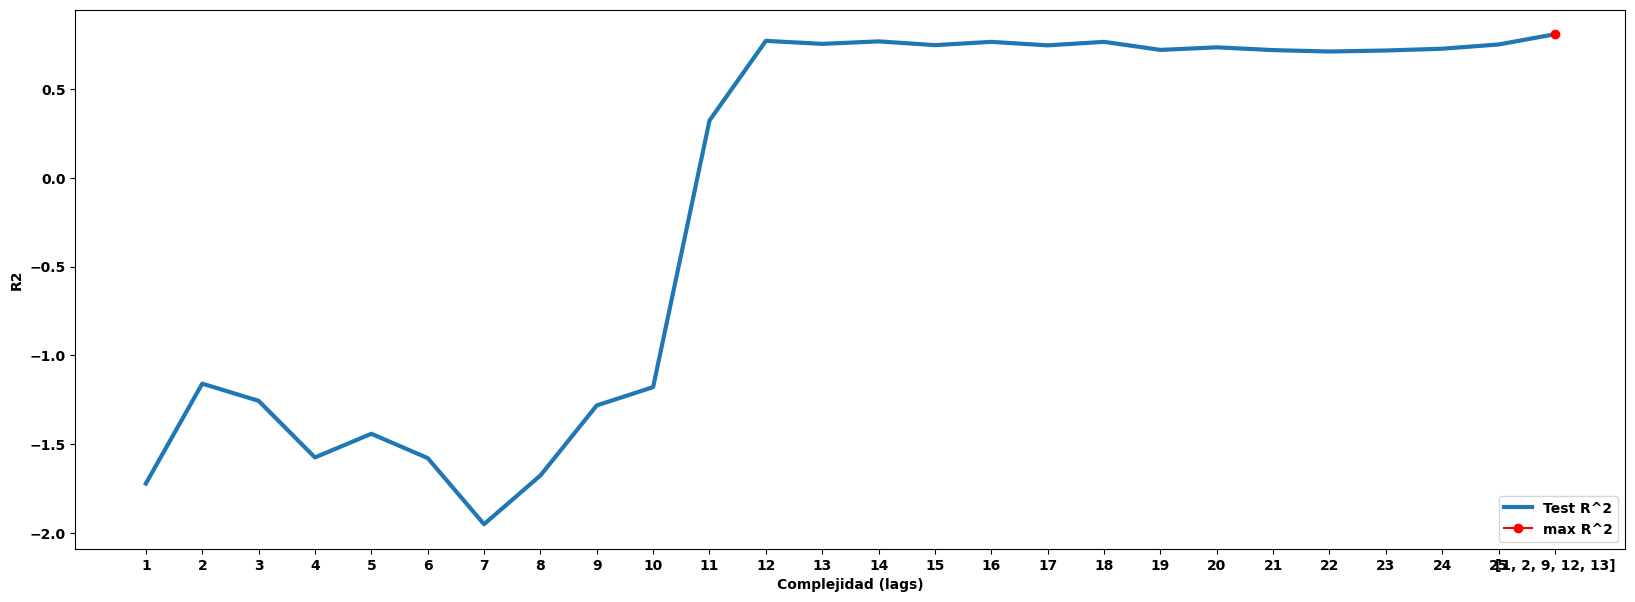

In [38]:
# Consideramos un rango para asignar el hiperparámetro 
hiper_param = np.arange(1,26).tolist()
hiper_param.append([1,2,9,12,13])
    
# Generamos previamente los vectores necesarios para ir calculando y guardando el rendimiento
test_r2 = np.zeros(len(hiper_param)) 

for i in range(len(hiper_param)):
    # Generamos un modelo para cada hiperparámetro, lo entrenamos y calculamos el R_cuadrado sobre datos de test 
    mod_bosque = ForecasterAutoreg(
                    regressor = RandomForestRegressor(random_state=77),
                    lags = hiper_param[i]
                )

    mod_bosque.fit(y=df_train['passengers'])
    test_r2[i] = r2_score(df_test, mod_bosque.predict(steps=horizonte).round())    

print("El mejor valor de lags podría ser =", hiper_param[np.argmax(test_r2)],
      " que consigue un R2 =", max(test_r2))

# Graficamos el R_cuadrado de test
fig = plt.figure(figsize=(20,7))
plt.plot(list(map(str, hiper_param)), test_r2, linewidth=3, label='Test R^2')
plt.plot(str(hiper_param[np.argmax(test_r2)]), max(test_r2),
         marker='o', color = "red", label="max R^2")

plt.xlabel('Complejidad (lags)')
plt.ylabel('R2')
plt.legend(loc = 'lower right')
plt.show()



La librería _skforecast_ cuenta con un método propio llamado `grid_search_forecaster` que es una implementación de _GridSearch_ para encontrar la combinación óptima de los hiperparámetros.

In [39]:
from skforecast.model_selection import grid_search_forecaster

# Modelo
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=77),
                lags      = 12 
             )

# Lags
lags_grid = [12, 13, [1,2,9,12,13]]

# Parámetros del regresor
param_grid = {'n_estimators': [100, 300, 500],
              'max_depth': [5, 10, 20, 30]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = df_train['passengers'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = horizonte,
                        refit              = False,
                        metric             = 'mean_absolute_error',
                        initial_train_size = int(len(df_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 36.


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:14<00:00,  4.73s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  9 12 13] 
  Parameters: {'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 92.72330598299007



In [40]:
from sklearn.ensemble import RandomForestRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg


mod_rf_grid = ForecasterAutoreg(
                regressor = RandomForestRegressor(n_estimators=500,
                                                  max_depth=5,
                                                  random_state=77),
                lags = [1,2,9,12,13]
                )

mod_rf_grid.fit(y=df_train['passengers'])
pred_rf_grid = mod_rf_grid.predict(steps=horizonte).round()

# Métricas de evaluación del modelo
print('Mean Absolute Error (MAE):', mean_absolute_error(df_test, pred_rf_grid))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(df_test, pred_rf_grid)*100)
print('Mean Squared Error (MSE):', mean_squared_error(df_test, pred_rf_grid))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(df_test, pred_rf_grid)))
print('R^2 coefficient of determination:', r2_score(df_test, pred_rf_grid))


Mean Absolute Error (MAE): 25.333333333333332
Mean Absolute Percentage Error: 4.947043394604873
Mean Squared Error (MSE): 1164.5
Root Mean Squared Error (RMSE): 34.12477106150311
R^2 coefficient of determination: 0.7897814172028021


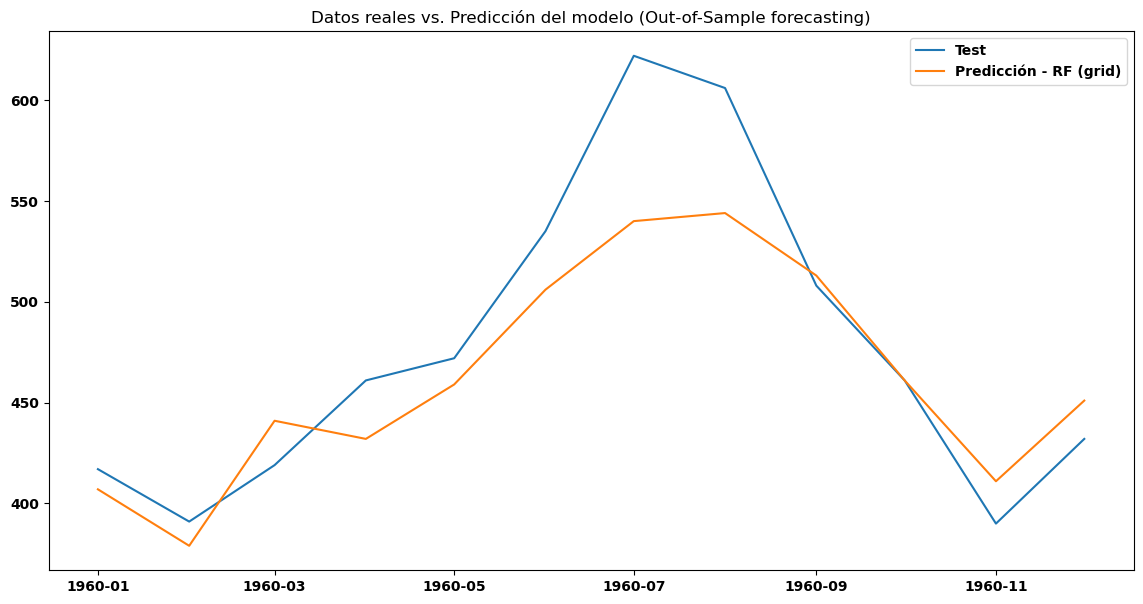

In [41]:
plt.plot(df_test, label='Test')
plt.plot(pred_rf_grid, label='Predicción - RF (grid)')
plt.title("Datos reales vs. Predicción del modelo (Out-of-Sample forecasting)")
plt.legend()
plt.show()

Además de este método podemos usar el análisis de complejidad como problemas de regresión para ver la evolución al cambiar cada hiperparámetro.

El mejor valor de n_estimator podría ser = 10  que consigue un R2 = 0.8460743853455754


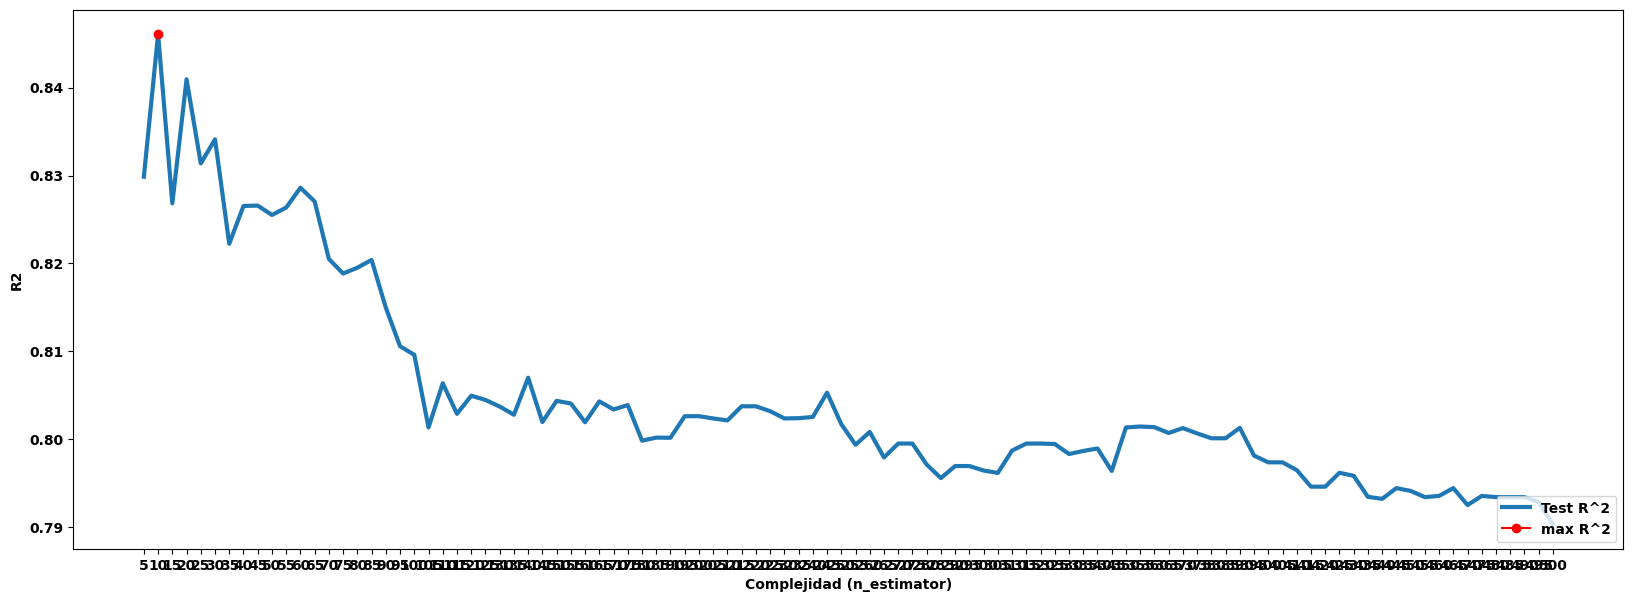

In [42]:
# Consideramos un rango para asignar el hiperparámetro 
hiper_param = np.arange(5,501,5)
    
# Generamos previamente los vectores necesarios para ir calculando y guardando el rendimiento
test_r2 = np.zeros(hiper_param.size) 

for i in range(hiper_param.size):
    # Generamos un modelo para cada hiperparámetro
    mod_bosque = ForecasterAutoreg(
                    regressor = RandomForestRegressor(n_estimators=hiper_param[i],
                                                      random_state=77),
                lags = [1,2,9,12,13]
                )

    mod_bosque.fit(y=df_train['passengers'])
    test_r2[i] = r2_score(df_test, mod_bosque.predict(steps=horizonte).round())    

print("El mejor valor de n_estimator podría ser =", hiper_param[np.argmax(test_r2)],
      " que consigue un R2 =", max(test_r2))

# Graficamos el R_cuadrado 
fig = plt.figure(figsize=(20,7))
plt.plot(hiper_param, test_r2, linewidth=3, label='Test R^2')
plt.plot(hiper_param[np.argmax(test_r2)], max(test_r2),
        marker='o', color = "red", label="max R^2")
plt.xticks(hiper_param)
plt.xlabel('Complejidad (n_estimator)')
plt.ylabel('R2')
plt.legend(loc = 'lower right')
plt.show()



El mejor valor de max_depth podría ser = 10  que consigue un R2 = 0.8496246634005447


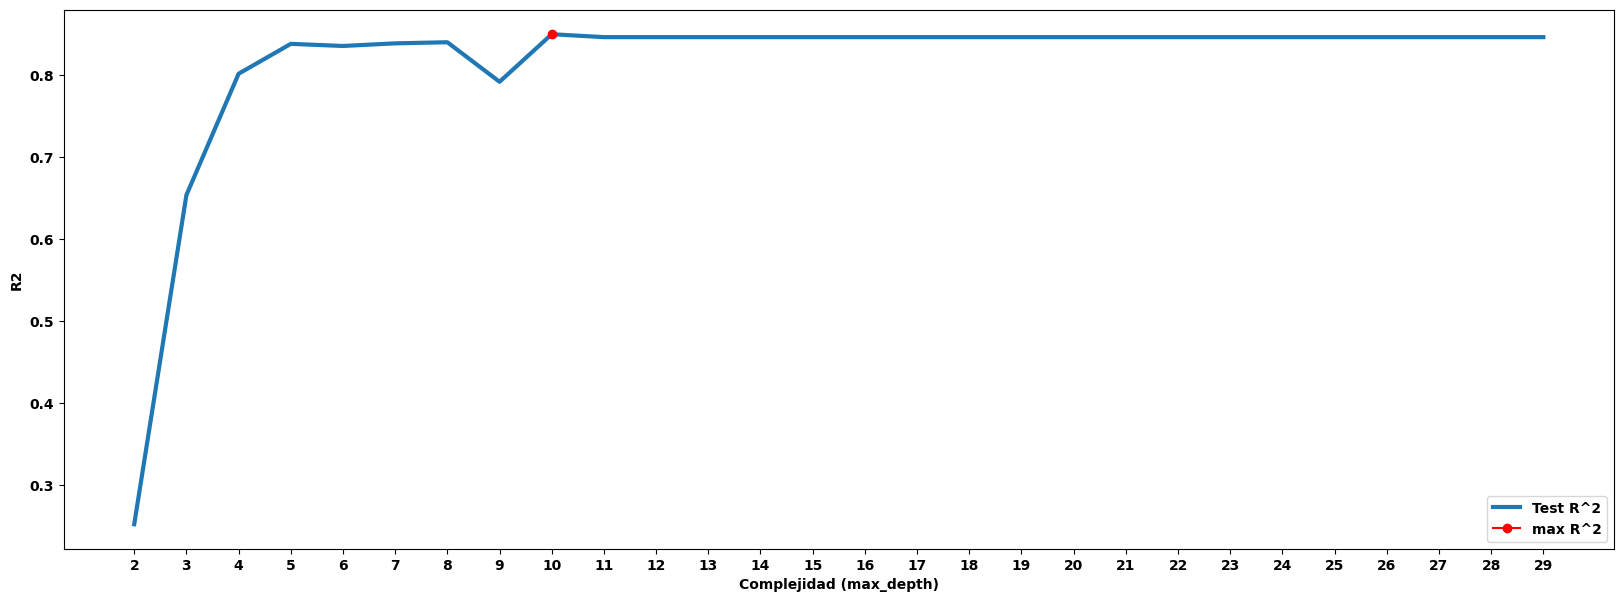

In [43]:
# Consideramos un rango para asignar el hiperparámetro 
hiper_param = np.arange(2,30)
    
# Generamos previamente los vectores necesarios para ir calculando y guardando el rendimiento
test_r2 = np.zeros(hiper_param.size) 

for i in range(hiper_param.size):
    # Generamos un modelo para cada hiperparámetro
    mod_bosque = ForecasterAutoreg(
                    regressor = RandomForestRegressor(max_depth=hiper_param[i],
                                                      n_estimators=10,
                                                      random_state=77),
                lags = [1,2,9,12,13]
                )

    mod_bosque.fit(y=df_train['passengers'])
    test_r2[i] = r2_score(df_test, mod_bosque.predict(steps=horizonte).round())    

print("El mejor valor de max_depth podría ser =", hiper_param[np.argmax(test_r2)],
      " que consigue un R2 =", max(test_r2))

# Graficamos el R_cuadrado de training versus de test
fig = plt.figure(figsize=(20,7))
plt.plot(hiper_param, test_r2, linewidth=3, label='Test R^2')
plt.plot(hiper_param[np.argmax(test_r2)], max(test_r2),
        marker='o', color = "red", label="max R^2")
plt.xticks(hiper_param)
plt.xlabel('Complejidad (max_depth)')
plt.ylabel('R2')
plt.legend(loc = 'lower right')
plt.show()



In [44]:
from sklearn.ensemble import RandomForestRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg


mod_rf_opt = ForecasterAutoreg(
                regressor = RandomForestRegressor(n_estimators=10,
                                                  max_depth=10,
                                                  random_state=77),
                lags = [1,2,9,12,13]
                )

mod_rf_opt.fit(y=df_train['passengers'])
pred_rf_opt = mod_rf_opt.predict(steps=horizonte).round()

# Métricas de evaluación del modelo
print('Mean Absolute Error (MAE):', mean_absolute_error(df_test, pred_rf_opt))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(df_test, pred_rf_opt)*100)
print('Mean Squared Error (MSE):', mean_squared_error(df_test, pred_rf_opt))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(df_test, pred_rf_opt)))
print('R^2 coefficient of determination:', r2_score(df_test, pred_rf_opt))


Mean Absolute Error (MAE): 22.666666666666668
Mean Absolute Percentage Error: 4.461731591199242
Mean Squared Error (MSE): 833.0
Root Mean Squared Error (RMSE): 28.861739379323623
R^2 coefficient of determination: 0.8496246634005447


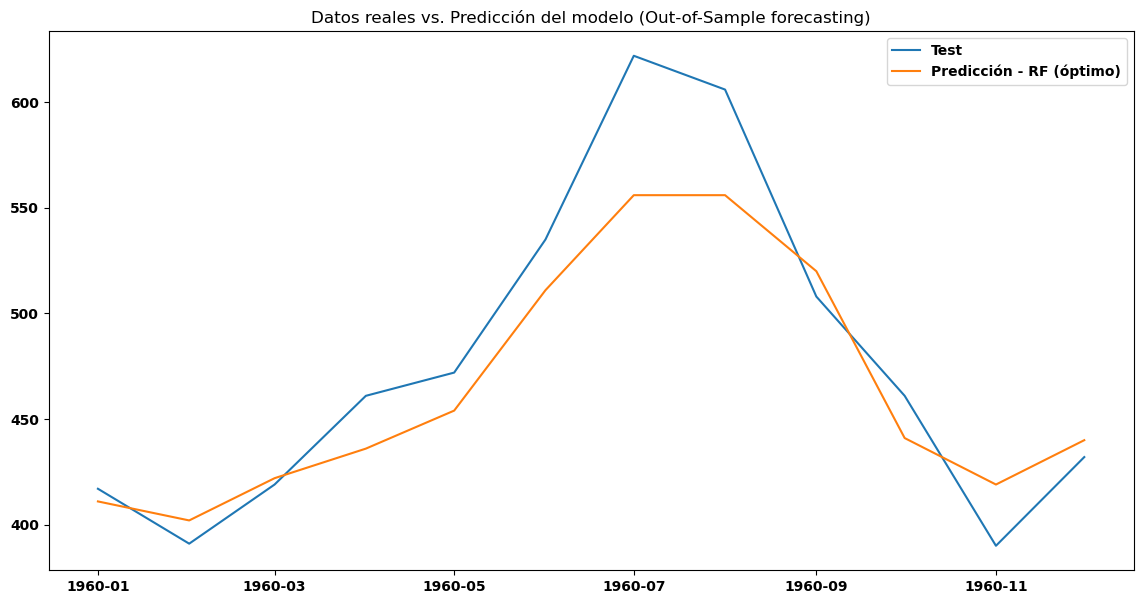

In [45]:
plt.plot(df_test, label='Test')
plt.plot(pred_rf_opt, label='Predicción - RF (óptimo)')
plt.title("Datos reales vs. Predicción del modelo (Out-of-Sample forecasting)")
plt.legend()
plt.show()

Gracias a la conversión realizada por _skforecast_ podemos aplicar distintas técnicas de ML que se usan en los problemas de regresión.

### XGBoost

Esta vez usamos los modelos de _XGBoost_ para modelar la serie temporal.

In [46]:
from xgboost import XGBRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg


mod_xgb = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=77),
                lags = 12
                )

mod_xgb.fit(y=df_train['passengers'])
pred_xgb = mod_xgb.predict(steps=horizonte).round()

# Métricas de evaluación del modelo
print('Mean Absolute Error (MAE):', mean_absolute_error(df_test, pred_xgb))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(df_test, pred_xgb)*100)
print('Mean Squared Error (MSE):', mean_squared_error(df_test, pred_xgb))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(df_test, pred_xgb)))
print('R^2 coefficient of determination:', r2_score(df_test, pred_xgb))


Mean Absolute Error (MAE): 27.25
Mean Absolute Percentage Error: 5.66949126520003
Mean Squared Error (MSE): 1046.5833333333333
Root Mean Squared Error (RMSE): 32.350940223327875
R^2 coefficient of determination: 0.8110680419815366


In [47]:
from skforecast.model_selection import grid_search_forecaster

forecaster = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=77),
                lags      = 12 
             )

# Lags
lags_grid = [12, 13, [1,2,9,12,13]]

# Parámetros del regresor
param_grid = {'n_estimators': [100, 300, 500],
              'max_depth': [5, 10, 20, 30],
              'learning_rate': [0.01, 0.1, 0.5, 1]}

results_grid_xgb = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = df_train['passengers'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = horizonte,
                        refit              = False,
                        metric             = 'mean_absolute_error',
                        initial_train_size = int(len(df_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 144.


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:12<00:00,  4.02s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  9 12 13] 
  Parameters: {'learning_rate': 1, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 85.41267788048947



In [48]:
from xgboost import XGBRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg


mod_xgb_grid = ForecasterAutoreg(
                regressor = XGBRegressor(n_estimators=300,
                                         max_depth=10,
                                         learning_rate=0.1,
                                         random_state=77),
                lags = [1,2,9,12,13]
                )

mod_xgb_grid.fit(y=df_train['passengers'])
pred_xgb_grid = mod_xgb_grid.predict(steps=horizonte).round()

# Métricas de evaluación del modelo
print('Mean Absolute Error (MAE):', mean_absolute_error(df_test, pred_xgb_grid))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(df_test, pred_xgb_grid)*100)
print('Mean Squared Error (MSE):', mean_squared_error(df_test, pred_xgb_grid))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(df_test, pred_xgb_grid)))
print('R^2 coefficient of determination:', r2_score(df_test, pred_xgb_grid))


Mean Absolute Error (MAE): 21.5
Mean Absolute Percentage Error: 4.177266784466506
Mean Squared Error (MSE): 855.0
Root Mean Squared Error (RMSE): 29.24038303442689
R^2 coefficient of determination: 0.8456531659153249


Ahora volvemos a analizar los hiperparámetros de uno en uno.

El mejor valor de n_estimator podría ser = 40  que consigue un R2 = 0.6894710185988437


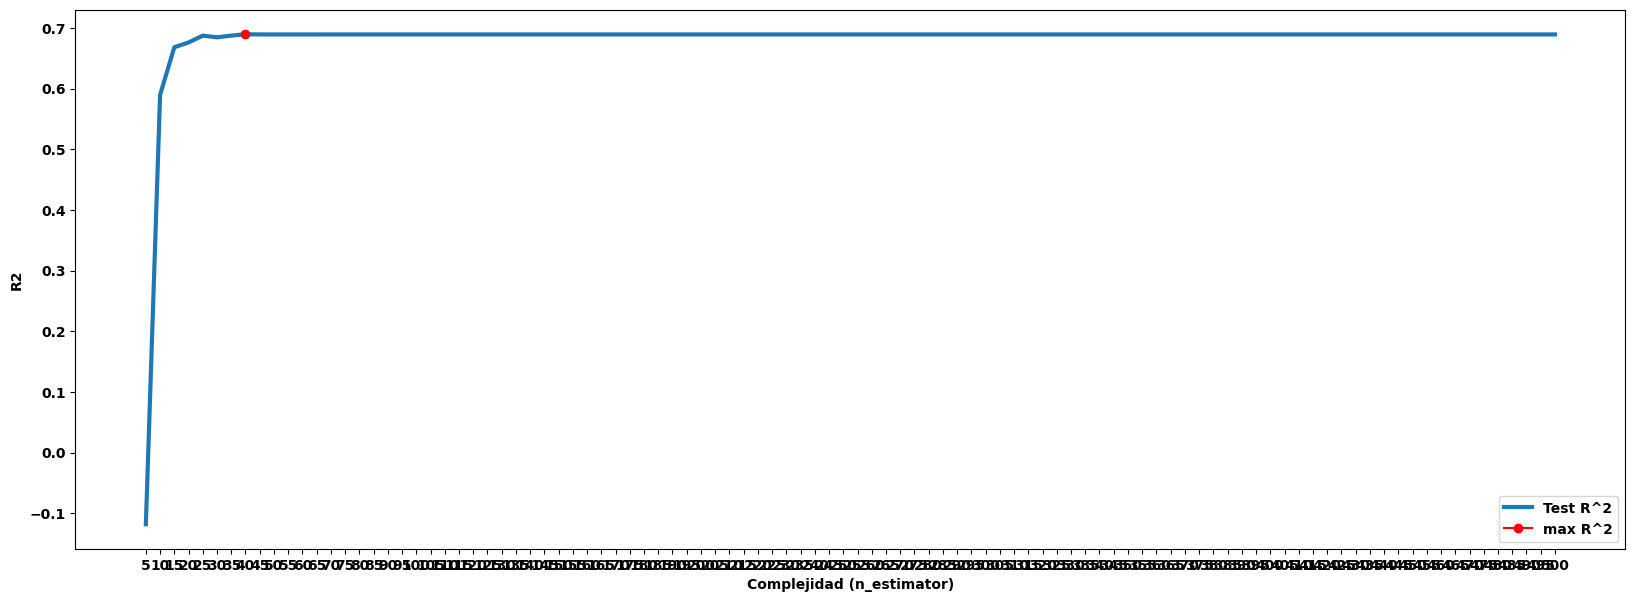

In [49]:
# Consideramos un rango para asignar el hiperparámetro 
hiper_param = np.arange(5,501,5)
    
# Generamos previamente los vectores necesarios para ir calculando y guardando el rendimiento
test_r2 = np.zeros(hiper_param.size) 

for i in range(hiper_param.size):
    # Generamos un modelo para cada hiperparámetro
    mod_bosque = ForecasterAutoreg(
                    regressor = XGBRegressor(n_estimators=hiper_param[i],
                                                      random_state=77),
                lags = [1,2,9,12,13]
                )

    mod_bosque.fit(y=df_train['passengers'])
    test_r2[i] = r2_score(df_test, mod_bosque.predict(steps=horizonte).round())    

print("El mejor valor de n_estimator podría ser =", hiper_param[np.argmax(test_r2)],
      " que consigue un R2 =", max(test_r2))

# Graficamos el R_cuadrado de training versus de test
fig = plt.figure(figsize=(20,7))
plt.plot(hiper_param, test_r2, linewidth=3, label='Test R^2')
plt.plot(hiper_param[np.argmax(test_r2)], max(test_r2),
        marker='o', color = "red", label="max R^2")
plt.xticks(hiper_param)
plt.xlabel('Complejidad (n_estimator)')
plt.ylabel('R2')
plt.legend(loc = 'lower right')
plt.show()



El mejor valor de max_depth podría ser = 7  que consigue un R2 = 0.8482406567011498


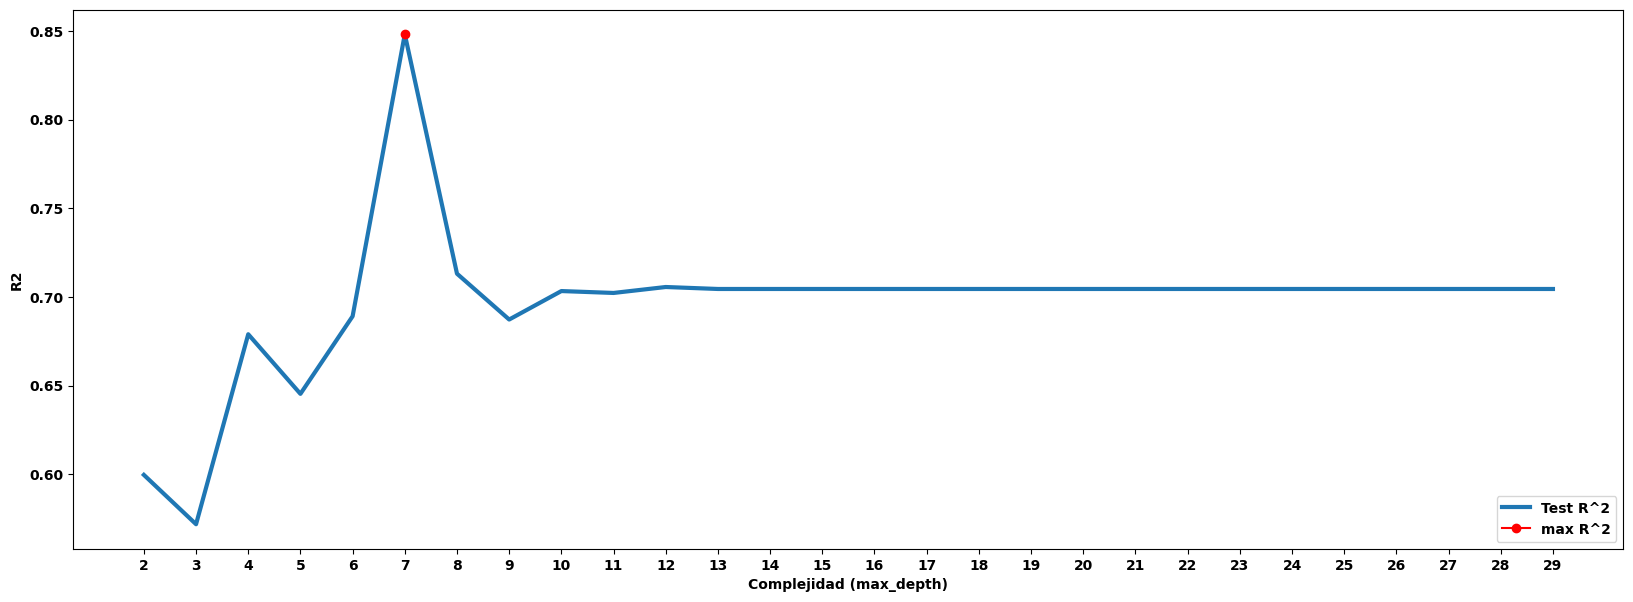

In [50]:
# Consideramos un rango para asignar el hiperparámetro 
hiper_param = np.arange(2,30)
    
# Generamos previamente los vectores necesarios para ir calculando y guardando el rendimiento
test_r2 = np.zeros(hiper_param.size) 

for i in range(hiper_param.size):
    # Generamos un modelo para cada hiperparámetro
    mod_bosque = ForecasterAutoreg(
                    regressor = XGBRegressor(max_depth=hiper_param[i],
                                                      n_estimators=50,
                                                      random_state=77),
                lags = [1,2,9,12,13]
                )

    mod_bosque.fit(y=df_train['passengers'])
    test_r2[i] = r2_score(df_test, mod_bosque.predict(steps=horizonte).round())    

print("El mejor valor de max_depth podría ser =", hiper_param[np.argmax(test_r2)],
      " que consigue un R2 =", max(test_r2))

# Graficamos el R_cuadrado
fig = plt.figure(figsize=(20,7))
plt.plot(hiper_param, test_r2, linewidth=3, label='Test R^2')
plt.plot(hiper_param[np.argmax(test_r2)], max(test_r2),
        marker='o', color = "red", label="max R^2")
plt.xticks(hiper_param)
plt.xlabel('Complejidad (max_depth)')
plt.ylabel('R2')
plt.legend(loc = 'lower right')
plt.show()



In [51]:
from xgboost import XGBRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg


mod_xgb_grid = ForecasterAutoreg(
                regressor = XGBRegressor(n_estimators=50,
                                         max_depth=10,
                                         random_state=77),
                lags = [1,2,9,12,13]
                )

mod_xgb_grid.fit(y=df_train['passengers'])
pred_xgb_grid = mod_xgb_grid.predict(steps=horizonte).round()

# Métricas de evaluación del modelo
print('Mean Absolute Error (MAE):', mean_absolute_error(df_test, pred_xgb_grid))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(df_test, pred_xgb_grid)*100)
print('Mean Squared Error (MSE):', mean_squared_error(df_test, pred_xgb_grid))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(df_test, pred_xgb_grid)))
print('R^2 coefficient of determination:', r2_score(df_test, pred_xgb_grid))


Mean Absolute Error (MAE): 31.833333333333332
Mean Absolute Percentage Error: 6.356785512520781
Mean Squared Error (MSE): 1643.5
Root Mean Squared Error (RMSE): 40.54010360124897
R^2 coefficient of determination: 0.7033110855927911


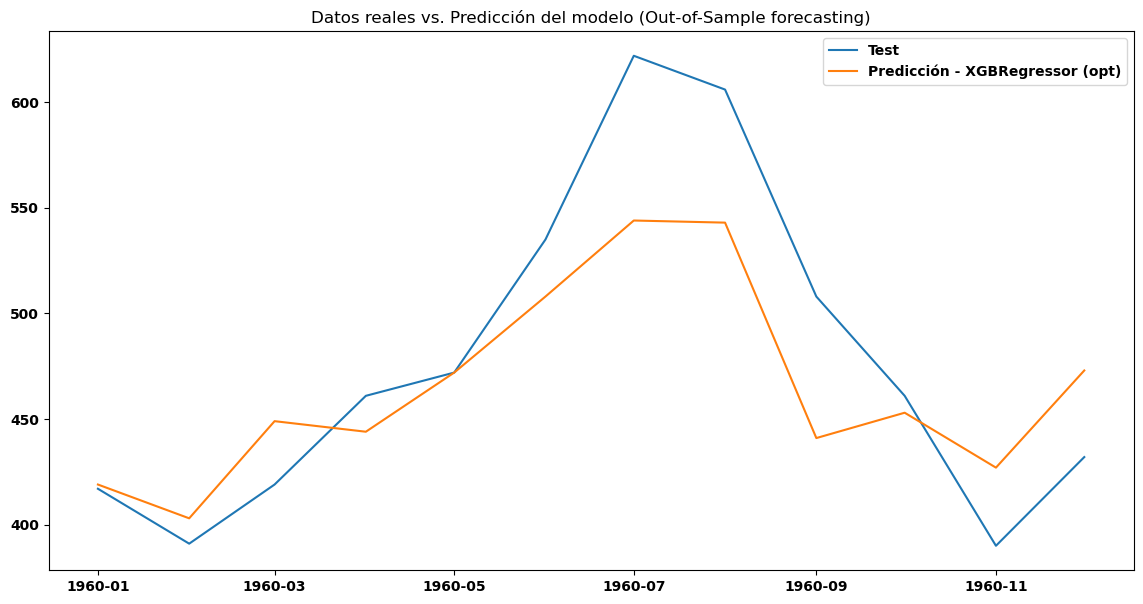

In [52]:
plt.plot(df_test, label='Test')
plt.plot(pred_xgb_grid, label='Predicción - XGBRegressor (opt)')
plt.title("Datos reales vs. Predicción del modelo (Out-of-Sample forecasting)")
plt.legend()
plt.show()

### LightGBM

LightGBM (`Light Gradient Boosting Machine`) es una herramienta de alto rendimiento desarrollado por _Microsoft_ que utiliza algoritmos de árboles de decisión para tareas de aprendizaje supervisado como regresión y clasificación.  

_LightGBM_ está escrito en __C++__, pero también tiene una interfaz de _Python_ y se puede usar junto con librerías populares de análisis de datos y aprendizaje automático, como pandas, _scikit-learn_ y _XGBoost_. 

In [53]:
from lightgbm import LGBMRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg

mod_lgbm = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=77),
                lags = 12
                )

mod_lgbm.fit(y=df_train['passengers'])
pred_lgbm = mod_lgbm.predict(steps=horizonte).round()

# Métricas de evaluación del modelo
print('Mean Absolute Error (MAE):', mean_absolute_error(df_test, pred_lgbm))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(df_test, pred_lgbm)*100)
print('Mean Squared Error (MSE):', mean_squared_error(df_test, pred_lgbm))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(df_test, pred_lgbm)))
print('R^2 coefficient of determination:', r2_score(df_test, pred_lgbm))


ModuleNotFoundError: No module named 'lightgbm'

In [ ]:
from skforecast.model_selection import grid_search_forecaster

forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=77),
                lags      = 12 
             )

# Lags used as predictors
lags_grid = [12, 13, [1,2,9,12,13]]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 300, 500],
              'max_depth': [5, 10, 20, 30],
              'learning_rate': [0.01, 0.1, 0.5, 1]}

results_grid_lgbm = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = df_train['passengers'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = horizonte,
                        refit              = False,
                        metric             = 'mean_absolute_error',
                        initial_train_size = int(len(df_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

NameError: name 'ForecasterAutoreg' is not defined

In [ ]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg

mod_lgbm_grid = ForecasterAutoreg(
                regressor = LGBMRegressor(n_estimators=100,
                                         max_depth=30,
                                         learning_rate=1,
                                         random_state=77),
                lags = [1,2,9,12,13]
                )

mod_lgbm_grid.fit(y=df_train['passengers'])
pred_lgbm_grid = mod_lgbm_grid.predict(steps=horizonte).round()

# Métricas de evaluación del modelo
print('Mean Absolute Error (MAE):', mean_absolute_error(df_test, pred_lgbm_grid))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(df_test, pred_lgbm_grid)*100)
print('Mean Squared Error (MSE):', mean_squared_error(df_test, pred_lgbm_grid))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(df_test, pred_lgbm_grid)))
print('R^2 coefficient of determination:', r2_score(df_test, pred_lgbm_grid))


NameError: name 'LGBMRegressor' is not defined

In [ ]:
plt.plot(df_test, label='Test')
plt.plot(pred_lgbm_grid, label='Predicción - LGBMRegressor (grid)')
plt.title("Datos reales vs. Predicción del modelo (Out-of-Sample forecasting)")
plt.legend()
plt.show()

NameError: name 'plt' is not defined

### CatBoost


_CatBoost_ es un framework open-source de _gradient boosting_ que está diseñado para funcionar bien especialmente con características categóricas sin necesidad de codificación one-hot u otros pasos de preprocesamiento.

In [54]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [55]:
from catboost import CatBoostRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg


mod_cat = ForecasterAutoreg(
                regressor = CatBoostRegressor(random_state=77, silent=True),
                lags = 12
                )

mod_cat.fit(y=df_train['passengers'])
pred_cat = mod_cat.predict(steps=horizonte).round()

# Métricas de evaluación del modelo
print('Mean Absolute Error (MAE):', mean_absolute_error(df_test, pred_cat))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(df_test, pred_cat)*100)
print('Mean Squared Error (MSE):', mean_squared_error(df_test, pred_cat))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(df_test, pred_cat)))
print('R^2 coefficient of determination:', r2_score(df_test, pred_cat))


Mean Absolute Error (MAE): 38.333333333333336
Mean Absolute Percentage Error: 7.276313474284418
Mean Squared Error (MSE): 2773.8333333333335
Root Mean Squared Error (RMSE): 52.6671940901861
R^2 coefficient of determination: 0.4992603587385481


In [56]:
from skforecast.model_selection import grid_search_forecaster

# Hyperparameter Grid search
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = CatBoostRegressor(random_state=77, silent=True),
                lags      = 12 
             )

# Lags used as predictors
lags_grid = [12, 13, [1,2,9,12,13]]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 300, 500],
              'max_depth': [5, 10],
              'learning_rate': [0.01, 0.1, 1]}

results_grid_cat = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = df_train['passengers'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = horizonte,
                        refit              = False,
                        metric             = 'mean_absolute_error',
                        initial_train_size = int(len(df_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 54.


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:09<00:00,  3.27s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  9 12 13] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
  Backtesting metric: 98.50239682468427



In [57]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg

mod_cat_grid = ForecasterAutoreg(
                regressor = CatBoostRegressor(n_estimators=300,
                                              max_depth=5,
                                              learning_rate=0.1,
                                              random_state=77,
                                              silent=True),
                lags = [1,2,9,12,13]
                )

mod_cat_grid.fit(y=df_train['passengers'])
pred_cat_grid = mod_cat_grid.predict(steps=horizonte).round()

# Métricas de evaluación del modelo
print('Mean Absolute Error (MAE):', mean_absolute_error(df_test, pred_cat_grid))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(df_test, pred_cat_grid)*100)
print('Mean Squared Error (MSE):', mean_squared_error(df_test, pred_cat_grid))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(df_test, pred_cat_grid)))
print('R^2 coefficient of determination:', r2_score(df_test, pred_cat_grid))


Mean Absolute Error (MAE): 35.75
Mean Absolute Percentage Error: 6.833489735615808
Mean Squared Error (MSE): 2338.25
Root Mean Squared Error (RMSE): 48.355454707819675
R^2 coefficient of determination: 0.5778930002356824


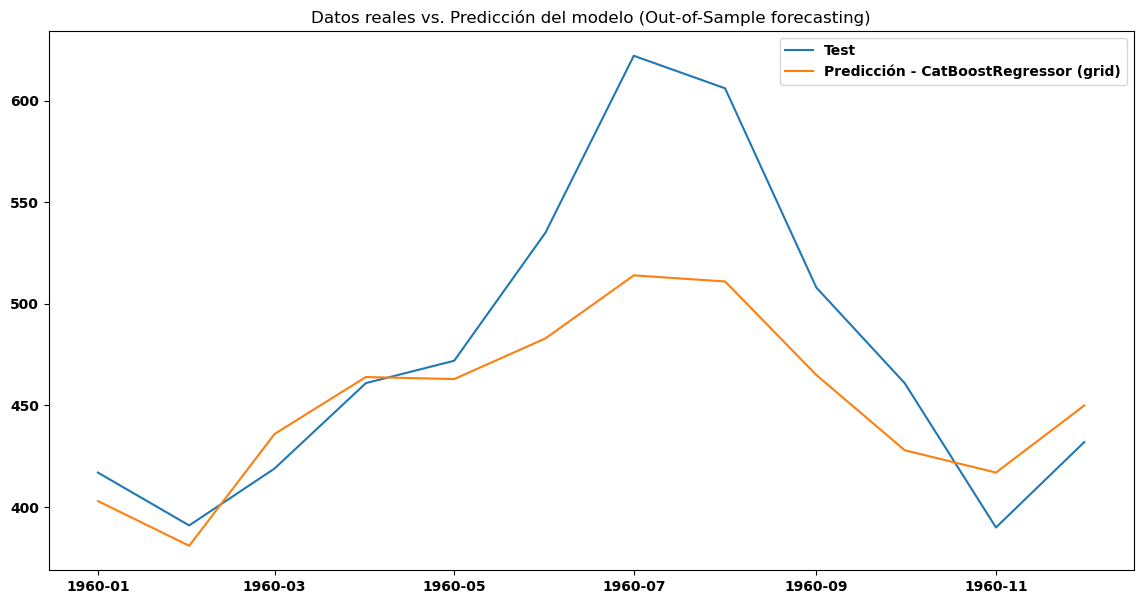

In [58]:
plt.plot(df_test, label='Test')
plt.plot(pred_cat_grid, label='Predicción - CatBoostRegressor (grid)')
plt.title("Datos reales vs. Predicción del modelo (Out-of-Sample forecasting)")
plt.legend()
plt.show()

### Bayesian search

La búsqueda en _grid_ puede generar buenos resultados, especialmente cuando se reduce el rango de búsqueda. Sin embargo, **no se tienen en cuanta los resultados obtenidos** en cada experimento, lo que **impide centrar la búsqueda en las regiones de mayor interés** para evitar los cálculos innecesarios.

Una alternativa es utilizar **métodos de optimización bayesianos** para buscar hiperparámetros. En términos generales, la optimización de hiperparámetros bayesianos consiste en crear un modelo probabilístico en el que la función objetivo es la métrica de validación del modelo (RMSE, AUC, precisión...). Con esta estrategia, **la búsqueda se redirige en cada iteración a las regiones de mayor interés**. El objetivo final es **reducir el número de combinaciones de hiperparámetros** con las que se evalúa el modelo, eligiendo solo los mejores candidatos. 

_Skforecast_ ofrece algunos motores de optimización bayesianos. Aquí usamos un ejempo el método **`Optuna`**. La búsqueda bayesiana solo se aplica a los hiperparámetros del modelo, y no a los retrasos, ya que se evalúan todos los _lags_ especificados por el usuario.

In [59]:
from skforecast.model_selection import  bayesian_search_forecaster

forecaster = ForecasterAutoreg(
                 regressor = XGBRegressor(random_state=77),
                 lags      = 12 
             )

# Lags
lags_grid = [12, 13, [1,2,9,12,13]]

# Parámetros del regresor
def search_space(trial):
    search_space  = {'n_estimators'     : trial.suggest_int('n_estimators', 100, 500, 100),
                     'max_depth'        : trial.suggest_int('max_depth', 5, 30, 5)} 
    return search_space

results, frozen_trial = bayesian_search_forecaster(
                            forecaster            = forecaster,
                            y                     = df_train['passengers'],
                            lags_grid             = lags_grid,
                            search_space          = search_space,
                            steps                 = horizonte,
                            metric                = 'mean_absolute_error',
                            refit                 = True,
                            initial_train_size    = int(len(df_train)*0.5),
                            fixed_train_size      = True,
                            n_trials              = 10,
                            random_state          = 77,
                            return_best           = True,
                            verbose               = False,
                            engine                = 'optuna',
                            kwargs_create_study   = {},
                            kwargs_study_optimize = {}
                        )

Number of models compared: 30,
         10 bayesian search in each lag configuration.


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:11<00:00,  3.89s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  9 12 13] 
  Parameters: {'n_estimators': 200, 'max_depth': 10}
  Backtesting metric: 26.16888127182469



In [60]:
from xgboost import XGBRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg

mod_xgb_grid_opt = ForecasterAutoreg(
                regressor = XGBRegressor(n_estimators=400,
                                         max_depth=5,
                                         random_state=77),
                lags = [1,2,9,12,13]
                )

mod_xgb_grid_opt.fit(y=df_train['passengers'])
pred_xgb_grid_opt = mod_xgb_grid_opt.predict(steps=horizonte).round()

# Métricas de evaluación del modelo
print('Mean Absolute Error (MAE):', mean_absolute_error(df_test, pred_xgb_grid_opt))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(df_test, pred_xgb_grid_opt)*100)
print('Mean Squared Error (MSE):', mean_squared_error(df_test, pred_xgb_grid_opt))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(df_test, pred_xgb_grid_opt)))
print('R^2 coefficient of determination:', r2_score(df_test, pred_xgb_grid_opt))


Mean Absolute Error (MAE): 34.416666666666664
Mean Absolute Percentage Error: 6.813683746685497
Mean Squared Error (MSE): 1986.0833333333333
Root Mean Squared Error (RMSE): 44.565494873650096
R^2 coefficient of determination: 0.6414670471013584


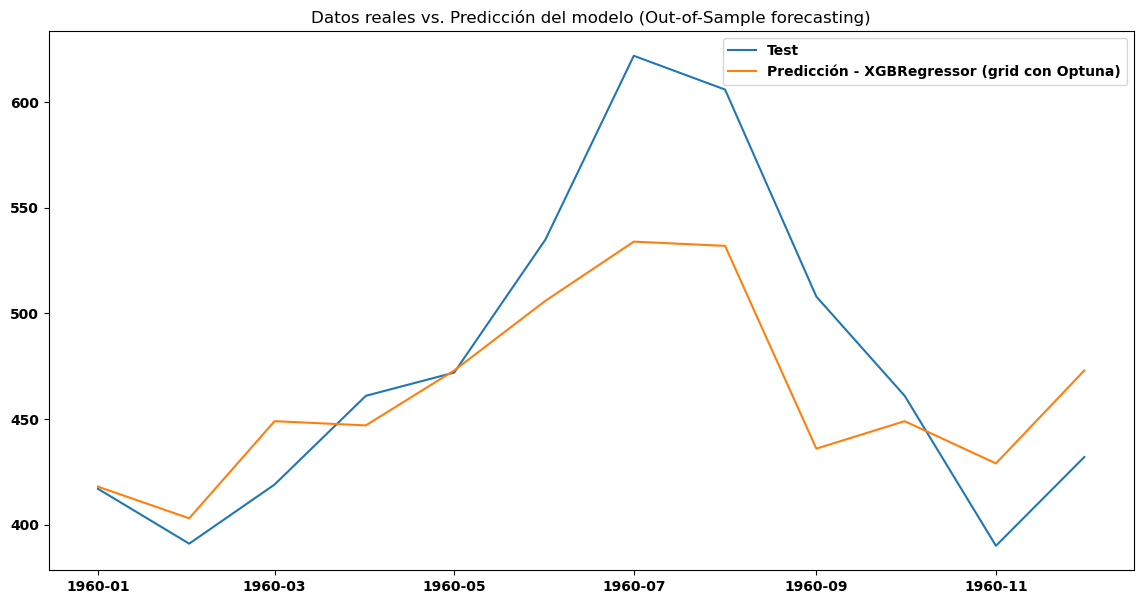

In [61]:
plt.plot(df_test, label='Test')
plt.plot(pred_xgb_grid_opt, label='Predicción - XGBRegressor (grid con Optuna)')
plt.title("Datos reales vs. Predicción del modelo (Out-of-Sample forecasting)")
plt.legend()
plt.show()

---

### **`Ejercicio 26`**

Vamos a analizar los datos de **`Sunspots Dataset`** que son números promediados mensuales de **manchas solares desde 1749 hasta 1983**.  


- Utilizamos el siguiente enlace para descargar los datos y crear una tabla tipo _DataFrame_ con ellos:
  - 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv'  
  

- Construimos la serie temporal, del modo que las fechas tipo `'1749-05-01'` formen los índices, y número de las manchas solares los valores de la serie.


---

In [62]:
# Solución 25.1.1

import pandas as pd
import matplotlib.pyplot as plt

# Load the Sunspots Quality dataset
df_spot = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv', index_col=False)
df_spot


,Month,Sunspots
0,1749-01,58.0
1,1749-02,62.6
2,1749-03,70.0
3,1749-04,55.7
4,1749-05,85.0
...,...,...
2815,1983-08,71.8
2816,1983-09,50.3
2817,1983-10,55.8
2818,1983-11,33.3


In [63]:
# Solución 25.1.2
# Convertir la columna en fechas tipo DatetimeIndex
df_spot['fechas'] = pd.to_datetime(df_spot['Month'], format='%Y-%m')

# Convertir la columna de fechas a los índices del DataFrame
df_spot.set_index('fechas', inplace=True)
df_spot.index.freq = 'MS'

# Remove the "year" and "month" columns
df_spot.drop(columns='Month', inplace=True)

df_spot

,Sunspots
fechas,
1749-01-01,58.0
1749-02-01,62.6
1749-03-01,70.0
1749-04-01,55.7
1749-05-01,85.0
...,...
1983-08-01,71.8
1983-09-01,50.3
1983-10-01,55.8


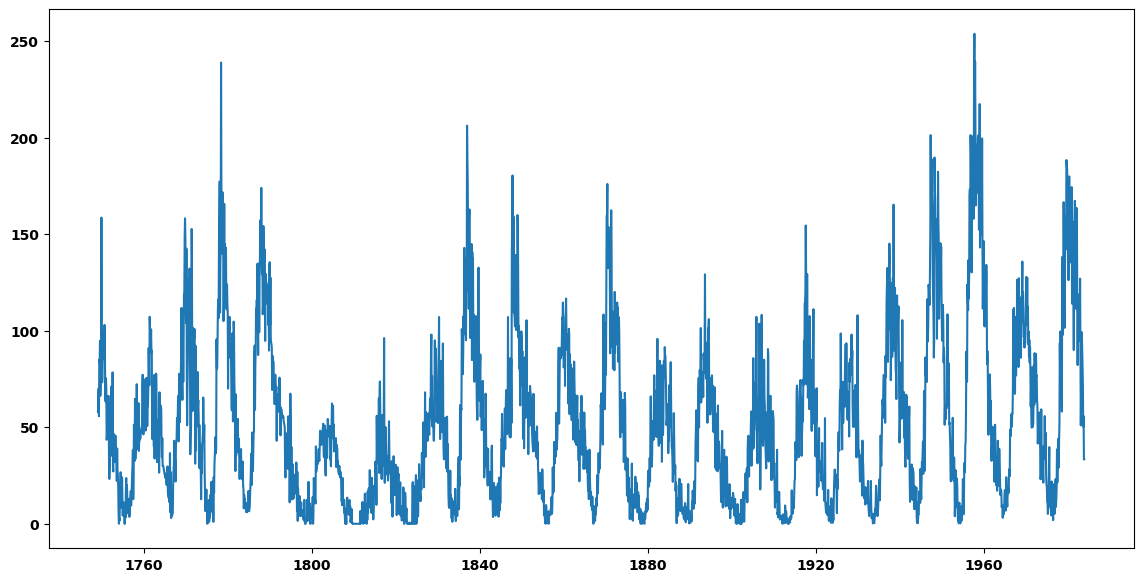

In [64]:
# Visualizar el DataFrame creado con los datos de la serie temporal
plt.plot(df_spot)
plt.show()

In [65]:
# Definir el periodo de prueba (horizonte de predicción)
horizonte = 12  # La cantidad de puntos a predecir
df_spot_test = df_spot.tail(horizonte)
df_spot_test

,Sunspots
fechas,
1983-01-01,84.3
1983-02-01,51.0
1983-03-01,66.5
1983-04-01,80.7
1983-05-01,99.2
1983-06-01,91.1
1983-07-01,82.2
1983-08-01,71.8
1983-09-01,50.3


In [66]:
# Filtrar la serie original para sacar el periodo de entrenamiento
df_spot_train = df_spot[~df_spot.index.isin(df_spot_test.index)]
df_spot_train

,Sunspots
fechas,
1749-01-01,58.0
1749-02-01,62.6
1749-03-01,70.0
1749-04-01,55.7
1749-05-01,85.0
...,...
1982-08-01,107.6
1982-09-01,118.8
1982-10-01,94.7


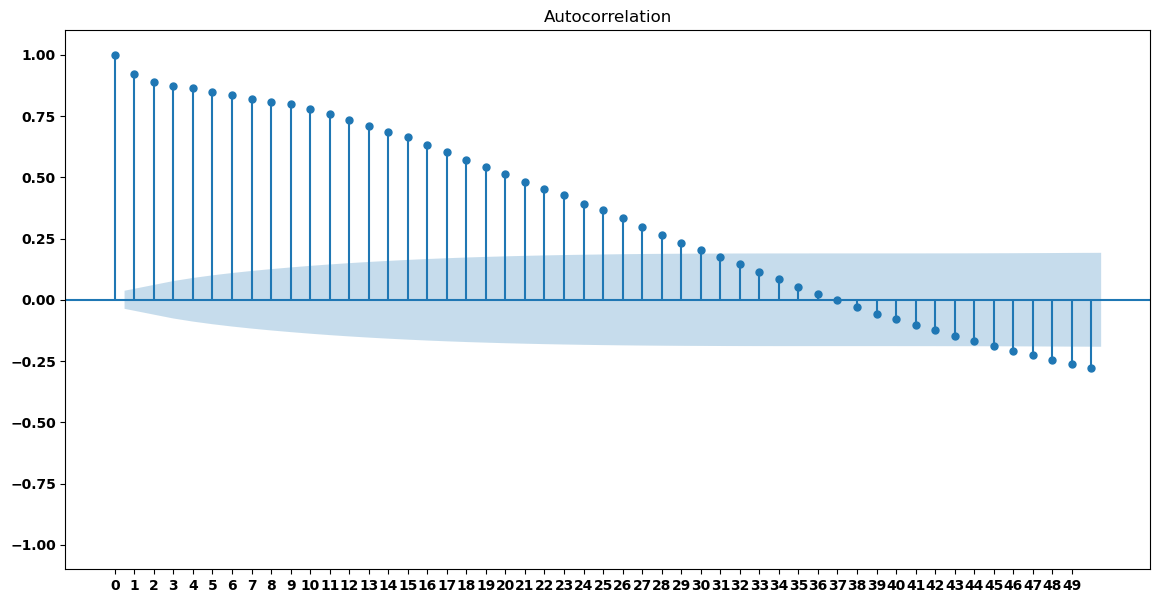

In [67]:
from statsmodels.graphics.tsaplots import plot_acf

rcParams['figure.figsize'] = 14, 7
plot_acf(df_spot, lags=50)
plt.xticks(np.arange(50))
plt.ylim(-1.1,1.1)
plt.show()

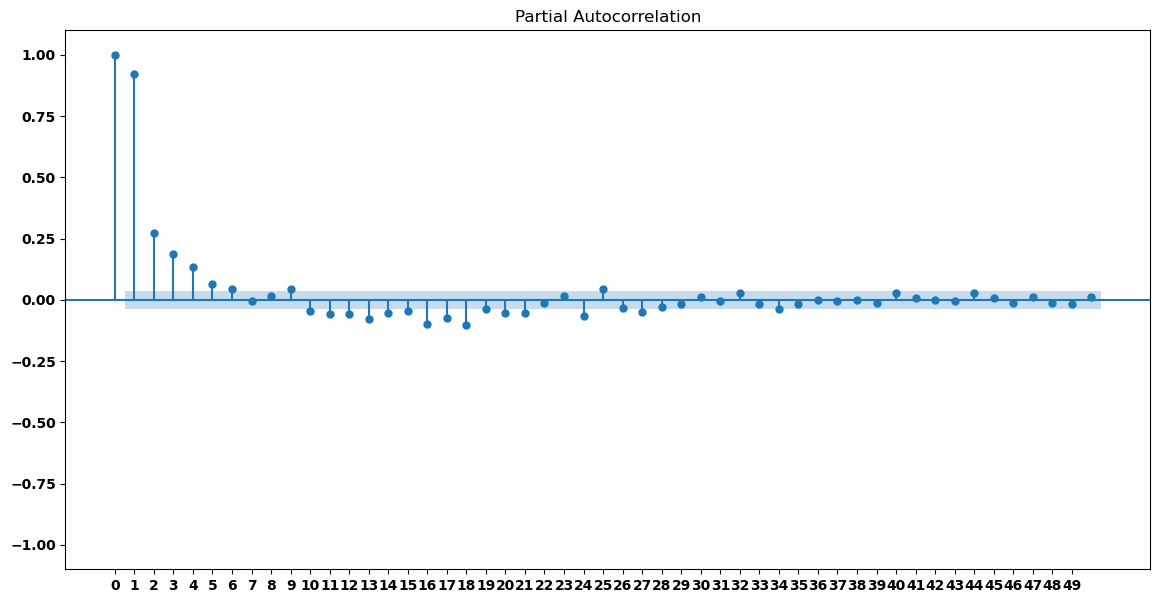

In [68]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(df_spot, lags=50, method='ywm')
plt.xticks(np.arange(50))
plt.ylim(-1.1,1.1)
plt.show()

Vemos que los retrasos con algo de autocorrelación parcial pueden llegar hasta el lag 34 aproximadamente.

El mejor valor de n_estimators podría ser = 110  que consigue un R2 = -0.8420977037531128


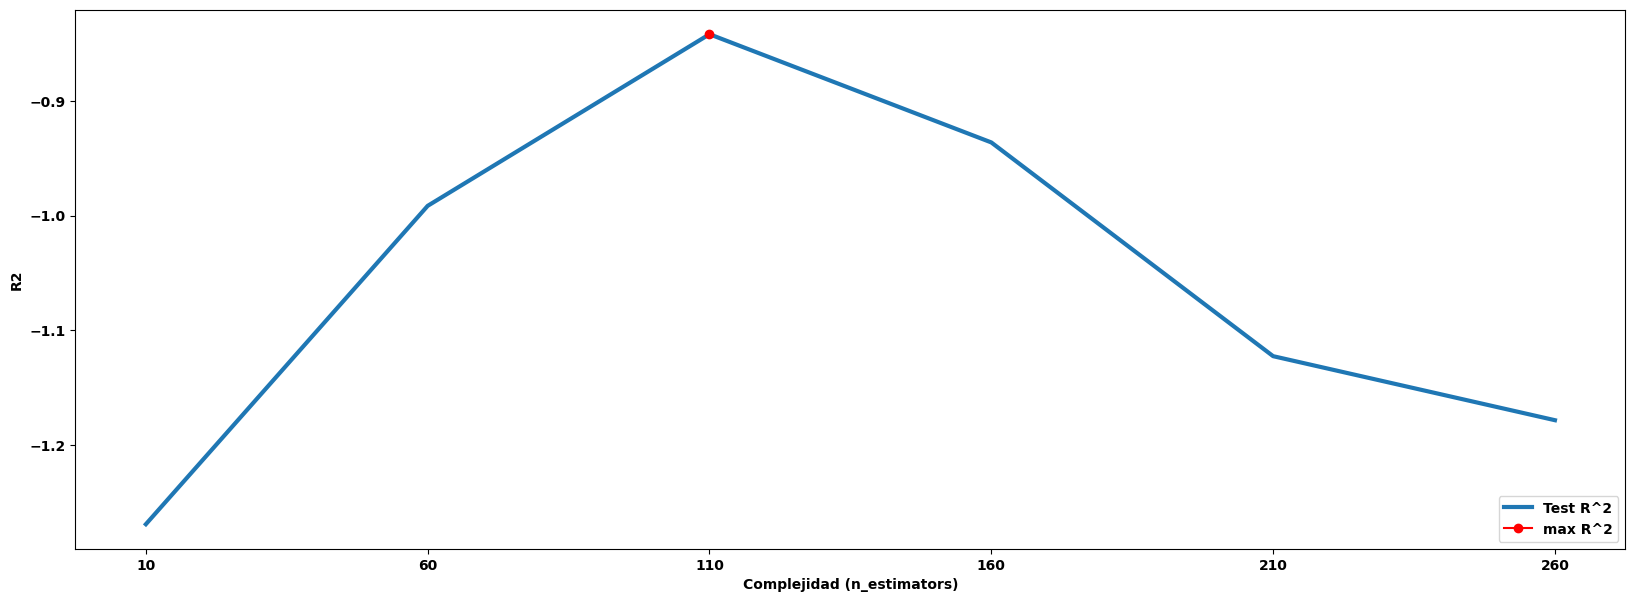

In [69]:
# Consideramos un rango para asignar el hiperparámetro 
hiper_param = np.arange(10,301,50)
    
# Generamos previamente los vectores necesarios para ir calculando y guardando el rendimiento
test_r2 = np.zeros(hiper_param.size) 

for i in range(hiper_param.size):
    # Generamos un modelo para cada hiperparámetro
    mod_bosque = ForecasterAutoreg(
                    regressor = RandomForestRegressor(n_estimators=hiper_param[i],
                                                      random_state=77),
                lags = 34
                )

    mod_bosque.fit(y=df_spot_train['Sunspots'])
    test_r2[i] = r2_score(df_spot_test, mod_bosque.predict(steps=horizonte))    

print("El mejor valor de n_estimators podría ser =", hiper_param[np.argmax(test_r2)],
      " que consigue un R2 =", max(test_r2))

# Graficamos el R_cuadrado 
fig = plt.figure(figsize=(20,7))
plt.plot(hiper_param, test_r2, linewidth=3, label='Test R^2')
plt.plot(hiper_param[np.argmax(test_r2)], max(test_r2),
        marker='o', color = "red", label="max R^2")
plt.xticks(hiper_param)
plt.xlabel('Complejidad (n_estimators)')
plt.ylabel('R2')
plt.legend(loc = 'lower right')
plt.show()



In [70]:
from sklearn.ensemble import RandomForestRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg


mod_spot_rf = ForecasterAutoreg(
                regressor = RandomForestRegressor(n_estimators=110,
                                                  max_depth=20,
                                                  random_state=77),
                lags = 34
                )

mod_spot_rf.fit(y=df_spot_train['Sunspots'])
pred_spot_rf = mod_spot_rf.predict(steps=horizonte).round()

# Métricas de evaluación del modelo
print('Mean Absolute Error (MAE):', mean_absolute_error(df_spot_test, pred_spot_rf))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(df_spot_test, pred_spot_rf)*100)
print('Mean Squared Error (MSE):', mean_squared_error(df_spot_test, pred_spot_rf))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(df_spot_test, pred_spot_rf)))
print('R^2 coefficient of determination:', r2_score(df_spot_test, pred_spot_rf))


Mean Absolute Error (MAE): 23.366666666666664
Mean Absolute Percentage Error: 46.37821965219938
Mean Squared Error (MSE): 762.5283333333333
Root Mean Squared Error (RMSE): 27.613915574096573
R^2 coefficient of determination: -0.7322556095861794


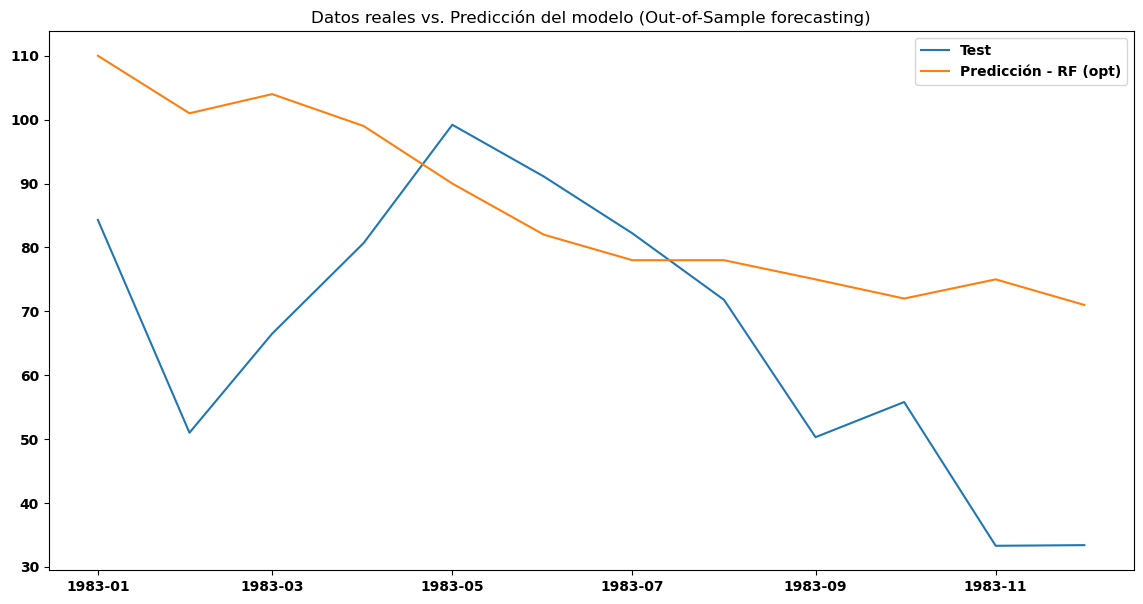

In [71]:
plt.plot(df_spot_test, label='Test')
plt.plot(pred_spot_rf, label='Predicción - RF (opt)')
plt.title("Datos reales vs. Predicción del modelo (Out-of-Sample forecasting)")
plt.legend()
plt.show()

---

### **`Ejercicio 27.1`**

Vamos a intentar a modelar la serie temporal con el objetivo de predecir los valores mensuales del último año. 

**`27.1.1`** Realiza una búsqueda mediante _Compexity Curve_ para encontrar el número óptimo de retrasos, teniendo en cuenta los siguientes puntos:

- Hasta `lag_34` inclusive
- Modelo: **XGBoost**
- `random_state=77`

**`27.1.2`** Teniendo en cuenta el valor óptimo calculado en el paso anterior para los retrasos, realiza una búsqueda mediante _Compexity Curve_ para encontrar el número óptimo de **árboles**, teniendo en cuenta los siguientes puntos:

- De 10 hasta 300 con pasos de 50
- `random_state=77`

**`27.1.3`** Teniendo en cuenta los valores óptimos calculados en los pasos anteriores, realiza una búsqueda mediante _Compexity Curve_ para encontrar el número óptimo de la **profundidad máxima**, teniendo en cuenta los siguientes puntos:

- De 2 a 30
- `random_state=77`

**`27.1.4`** Construye un modelo con los hiperparámetros óptimos que hayas calculado y calcula las métricas de calidad del modelo y de tus predicciones:

- Las métricas de "_Out-of-sample performance_": MAE, MAPE, MSE, RMSE y R2.

**`27.1.5`** Saca la gráfica de "_Datos reales vs. Predicción del modelo (Out-of-Sample forecasting)_" y **analiza y compara los resultados** de este modelo con el último modelo contruido en la sesión.

**`27.1.1`** Realiza una búsqueda mediante _Compexity Curve_ para encontrar el número óptimo de retrasos, teniendo en cuenta los siguientes puntos:

- Hasta `lag_34` inclusive
- Modelo: **XGBoost**
- `random_state=77`

El mejor valor de lags podría ser = 13  que consigue un R2 = -0.3485889422772215


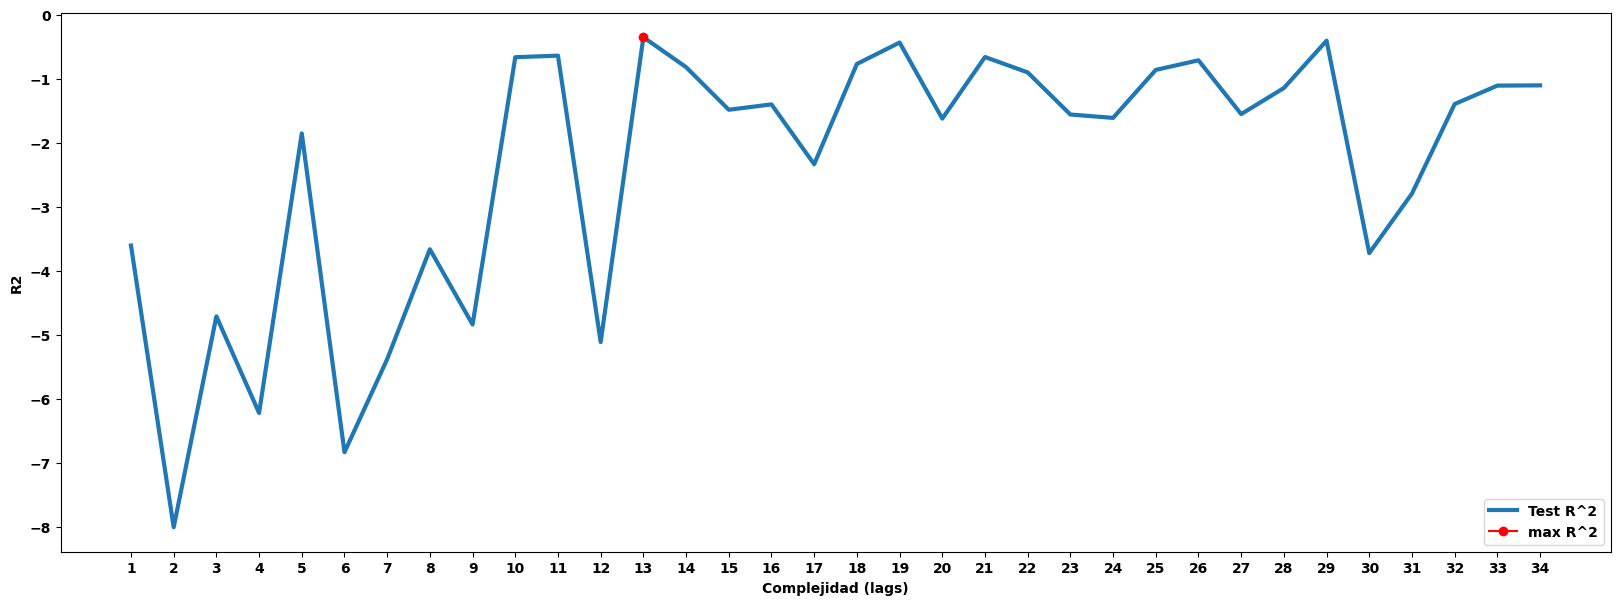

In [80]:
# Lags
lags_ej = np.arange(1,35)

test_r2_ej = np.zeros(lags_ej.size)

for i in range(lags_ej.size):
    forecaster_ej = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=77),
                lags      = int(lags_ej[i])
             )
    forecaster_ej.fit(y=df_spot_train['Sunspots'])
    test_r2_ej[i] = r2_score(df_spot_test, forecaster_ej.predict(steps=horizonte))

print("El mejor valor de lags podría ser =", lags_ej[np.argmax(test_r2_ej)],
      " que consigue un R2 =", max(test_r2_ej))

# Graficamos el R_cuadrado de training versus de test
fig = plt.figure(figsize=(20,7))
plt.plot(lags_ej, test_r2_ej, linewidth=3, label='Test R^2')
plt.plot(lags_ej[np.argmax(test_r2_ej)], max(test_r2_ej),
        marker='o', color = "red", label="max R^2")
plt.xticks(lags_ej)
plt.xlabel('Complejidad (lags)')
plt.ylabel('R2')
plt.legend(loc = 'lower right')
plt.show()

**`27.1.2`** Teniendo en cuenta el valor óptimo calculado en el paso anterior para los retrasos, realiza una búsqueda mediante _Compexity Curve_ para encontrar el número óptimo de **árboles**, teniendo en cuenta los siguientes puntos:

- De 10 hasta 300 con pasos de 50
- `random_state=77`

El mejor valor de n_estimator podría ser = 60  que consigue un R2 = -0.3136414908353735


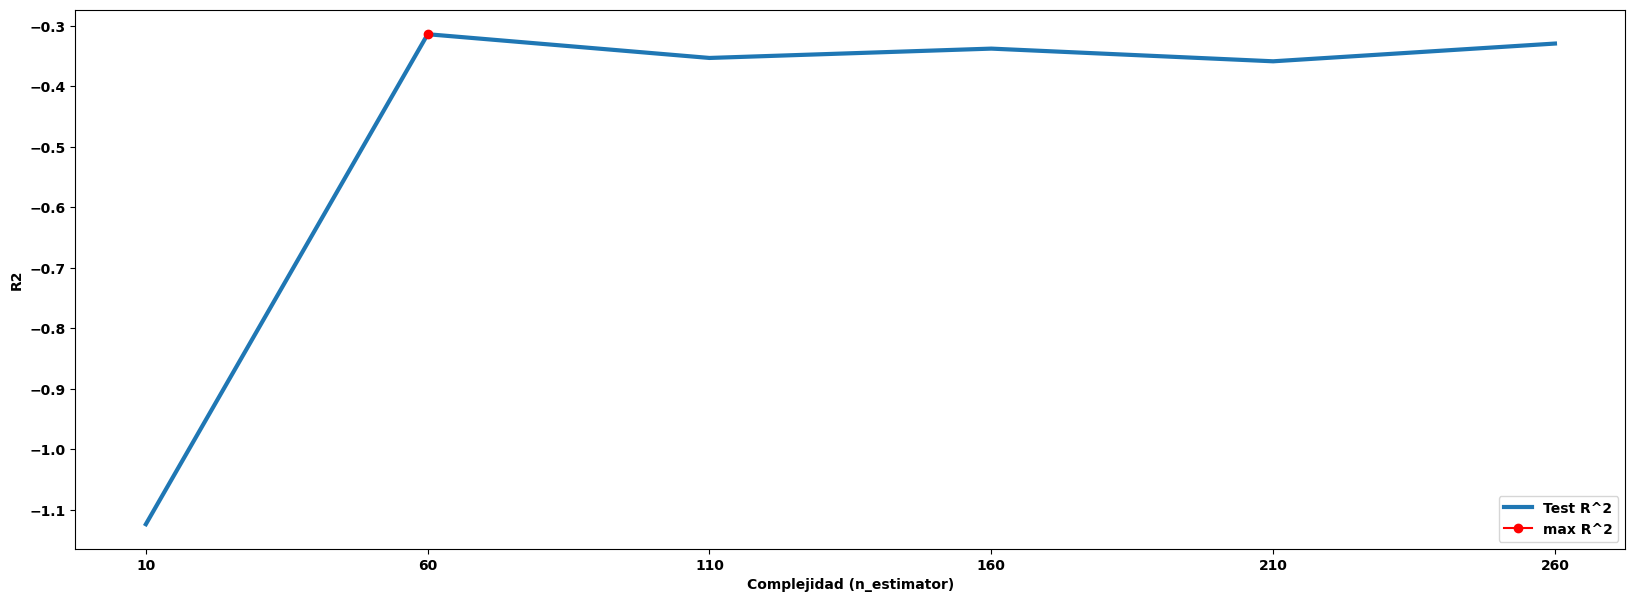

In [82]:
range_trees = np.arange(10,301,50)

test_r2_trees = np.zeros(range_trees.size)

for i in range(range_trees.size):
    forecaster_trees = ForecasterAutoreg(
        regressor=XGBRegressor(n_estimators=range_trees[i],
                               random_state=77),
                               lags=13
    )

    forecaster_trees.fit(y=df_spot_train['Sunspots'])
    test_r2_trees[i] = r2_score(df_spot_test, forecaster_trees.predict(steps=horizonte))

print("El mejor valor de n_estimator podría ser =", range_trees[np.argmax(test_r2_trees)],
      " que consigue un R2 =", max(test_r2_trees))

fig = plt.figure(figsize=(20,7))
plt.plot(range_trees, test_r2_trees, linewidth=3, label='Test R^2')
plt.plot(range_trees[np.argmax(test_r2_trees)], max(test_r2_trees),
        marker='o', color = "red", label="max R^2")
plt.xticks(range_trees)
plt.xlabel('Complejidad (n_estimator)')
plt.ylabel('R2')
plt.legend(loc = 'lower right')
plt.show()

**`27.1.3`** Teniendo en cuenta los valores óptimos calculados en los pasos anteriores, realiza una búsqueda mediante _Compexity Curve_ para encontrar el número óptimo de la **profundidad máxima**, teniendo en cuenta los siguientes puntos:

- De 2 a 30
- `random_state=77`

El mejor valor de max_depth podría ser = 13  que consigue un R2 = -0.30731893669618304


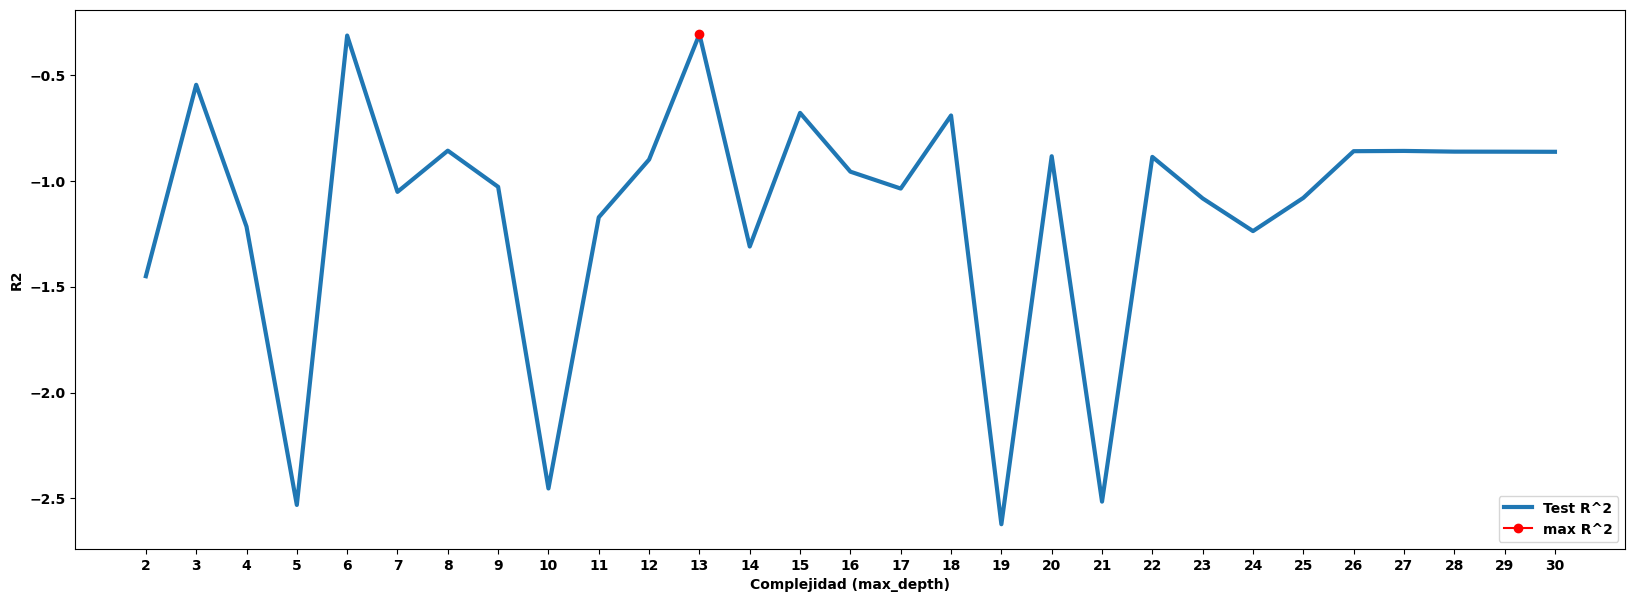

In [83]:
range_depth = np.arange(2,31)
    
test_r2_depth = np.zeros(range_depth.size) 

for i in range(range_depth.size):
    forecaster_depth = ForecasterAutoreg(
                    regressor = XGBRegressor(max_depth=range_depth[i],
                                                      n_estimators=60,
                                                      random_state=77),
                lags = 13
                )

    forecaster_depth.fit(y=df_spot_train['Sunspots'])
    test_r2_depth[i] = r2_score(df_spot_test, forecaster_depth.predict(steps=horizonte))    

print("El mejor valor de max_depth podría ser =", range_depth[np.argmax(test_r2_depth)],
      " que consigue un R2 =", max(test_r2_depth))

fig = plt.figure(figsize=(20,7))
plt.plot(range_depth, test_r2_depth, linewidth=3, label='Test R^2')
plt.plot(range_depth[np.argmax(test_r2_depth)], max(test_r2_depth),
        marker='o', color = "red", label="max R^2")
plt.xticks(range_depth)
plt.xlabel('Complejidad (max_depth)')
plt.ylabel('R2')
plt.legend(loc = 'lower right')
plt.show()

**`27.1.4`** Construye un modelo con los hiperparámetros óptimos que hayas calculado y calcula las métricas de calidad del modelo y de tus predicciones:

- Las métricas de "_Out-of-sample performance_": MAE, MAPE, MSE, RMSE y R2.

In [85]:
forecaster_opt = ForecasterAutoreg(
                    regressor = XGBRegressor(max_depth=13,
                                                      n_estimators=60,
                                                      random_state=77),
                lags = 13
                )
forecaster_opt.fit(y=df_spot_train['Sunspots'])
pred_forecaster_opt = forecaster_opt.predict(steps=horizonte)

In [86]:
print('Mean Absolute Error (MAE):', mean_absolute_error(df_spot_test, pred_forecaster_opt))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(df_spot_test, pred_forecaster_opt)*100)
print('Mean Squared Error (MSE):', mean_squared_error(df_spot_test, pred_forecaster_opt))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(df_spot_test, pred_forecaster_opt)))
print('R^2 coefficient of determination:', r2_score(df_spot_test, pred_forecaster_opt))

Mean Absolute Error (MAE): 20.30670897165934
Mean Absolute Percentage Error: 39.88299611234864
Mean Squared Error (MSE): 575.4738067623801
Root Mean Squared Error (RMSE): 23.989035136127924
R^2 coefficient of determination: -0.30731893669618304


**`27.1.5`** Saca la gráfica de "_Datos reales vs. Predicción del modelo (Out-of-Sample forecasting)_" y **analiza y compara los resultados** de este modelo con el último modelo contruido en la sesión.

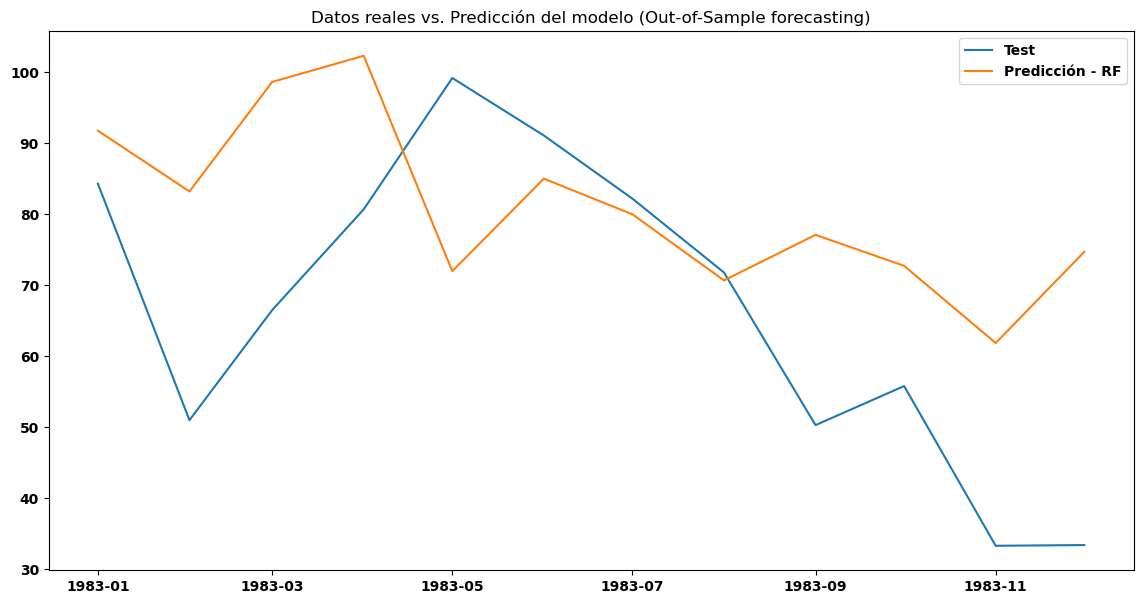

In [87]:
plt.plot(df_spot_test, label='Test')
plt.plot(pred_forecaster_opt, label='Predicción - RF')
plt.title("Datos reales vs. Predicción del modelo (Out-of-Sample forecasting)")
plt.legend()
plt.show()

Los resultados muestran que el modelo no ha realizado una buena predicción. Un R² negativo implica que el modelo es peor que simplemente tomar la media de los datos como predicción para cada punto, lo cual no es deseable en un modelo predictivo.

La razón detrás de esto puede ser que el modelo está sobreajustado, los hiperparámetros no están bien afinados, o simplemente el modelo seleccionado no es adecuado para la serie temporal dada. También es posible que se necesite más preprocesamiento de datos, como la diferenciación para estabilizar la media de la serie temporal o la transformación para estabilizar la varianza.

---